# Laminar model comparison using cross-validation error

This tutorial demonstrates how to perform laminar inference using model comparison based on cross-validation error as a metric of model fit, described in [Bonaiuto et al., 2018, Non-invasive laminar inference with MEG: Comparison of methods and source inversion algorithms](https://doi.org/10.1016/j.neuroimage.2017.11.068). A 20Hz oscillation is simulated at a particular cortical location in various layers. Source reconstruction is performed using the Empirical Bayesian Beamformer on the simulated sensor data using forward models based on different layer meshes. These models are then compared using cross-validation error. Cross-validation error is computed by fitting the model N times, each time leaving out a certain percentage of the channels and seeing how well the resulting model can predict the signal in those channels

## Setting up the simulations

Simulations are based on an existing dataset, which is used to define the sampling rate, number of trials, duration of each trial, and the channel layout.

In [1]:
%env SUBJECTS_DIR=../test_data/fs

env: SUBJECTS_DIR=../test_data/fs


In [2]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tempfile
from IPython.display import Image
import base64

from lameg.invert import coregister, invert_ebb
from lameg.simulate import run_current_density_simulation
from lameg.laminar import model_comparison
from lameg.surf import LayerSurfaceSet
from lameg.util import get_fiducial_coords
from lameg.viz import show_surface
import spm_standalone

# Subject information for data to base the simulations on
subj_id = 'sub-104'
ses_id = 'ses-01'

# Fiducial coil coordinates
fid_coords = get_fiducial_coords(subj_id, '../test_data/participants.tsv')

# Data file to base simulations on
data_file = os.path.join(
    '../test_data', 
    subj_id,
    'meg',
    ses_id, 
    f'spm/spm-converted_autoreject-{subj_id}-{ses_id}-001-btn_trial-epo.mat'
)

spm = spm_standalone.initialize()

The simulations will be based on a forward model using the multilayer mesh, and the model comparison will use each layer mesh

In [3]:
surf_set_bilam = LayerSurfaceSet(subj_id, 2)
surf_set = LayerSurfaceSet(subj_id, 11)

We're going to copy the data file to a temporary directory and direct all output there.

In [4]:
# Extract base name and path of data file
data_path, data_file_name = os.path.split(data_file)
data_base = os.path.splitext(data_file_name)[0]

# Where to put simulated data
tmp_dir = tempfile.mkdtemp()

# Copy data files to tmp directory
shutil.copy(
    os.path.join(data_path, f'{data_base}.mat'), 
    os.path.join(tmp_dir, f'{data_base}.mat')
)
shutil.copy(
    os.path.join(data_path, f'{data_base}.dat'), 
    os.path.join(tmp_dir, f'{data_base}.dat')
)

# Construct base file name for simulations
base_fname = os.path.join(tmp_dir, f'{data_base}.mat')

Invert the subject's data using the multilayer mesh. This step only has to be done once - this is just to compute the forward model that will be used in the simulations

In [5]:
# Patch size to use for inversion (in this case it matches the simulated patch size)
patch_size = 5
# Number of temporal modes to use for EBB inversion
n_temp_modes = 4

# Coregister data to multilayer mesh
coregister(
    fid_coords, 
    base_fname,
    surf_set,
    spm_instance=spm
)

# Run inversion
[_,_] = invert_ebb(
    base_fname, 
    surf_set,
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    spm_instance=spm
)

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 
Initialising batch system... done.


------------------------------------------------------------------------
27-Oct-2025 10:27:26 - Running job #1
------------------------------------------------------------------------
27-Oct-2025 10:27:26 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           10:27:27 - 27/10/2025
multilayer.11.ds.link_vector.fixed
undoing the G3BR balancing for the gradiometer definition
creating layout from cfg.grad
undoing the G3BR balancing

27-Oct-2025 10:39:08 - Done    'Source inversion, iterative'
27-Oct-2025 10:39:08 - Done



## Simulating a signal on the pial surface
We're going to simulate 1s of a 20Hz sine wave with a dipole moment of 10nAm

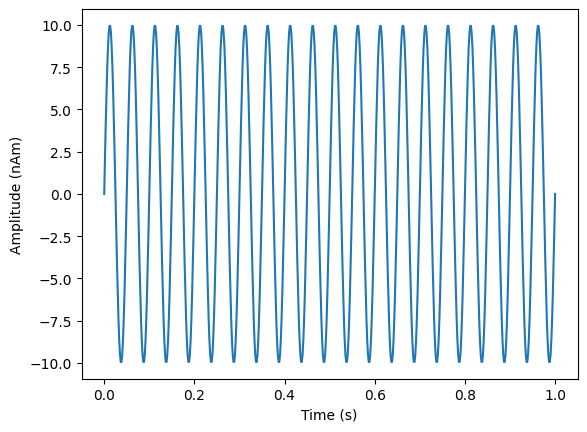

In [6]:
# Frequency of simulated sinusoid (Hz)
freq = 20
# Strength of simulated activity (nAm)
dipole_moment = 10
# Sampling rate (must match the data file)
s_rate = 600

# Generate 1s of a sine wave at a sampling rate of 600Hz (to match the data file)
time = np.linspace(0,1,s_rate+1)
sim_signal = np.sin(time*freq*2*np.pi).reshape(1,-1)

plt.plot(time,dipole_moment*sim_signal[0,:])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (nAm)')

We need to pick a location (mesh vertex) to simulate at

In [5]:
# Vertex to simulate activity at
sim_vertex=50492

cam_view = [335, 9.5, 51,
            60, 37, 17,
            0, 0, 1]
plot = show_surface(
    surf_set,
    marker_vertices=sim_vertex,
    marker_size=5,
    camera_view=cam_view
)

Output()

In [6]:
plot.fetch_screenshot()

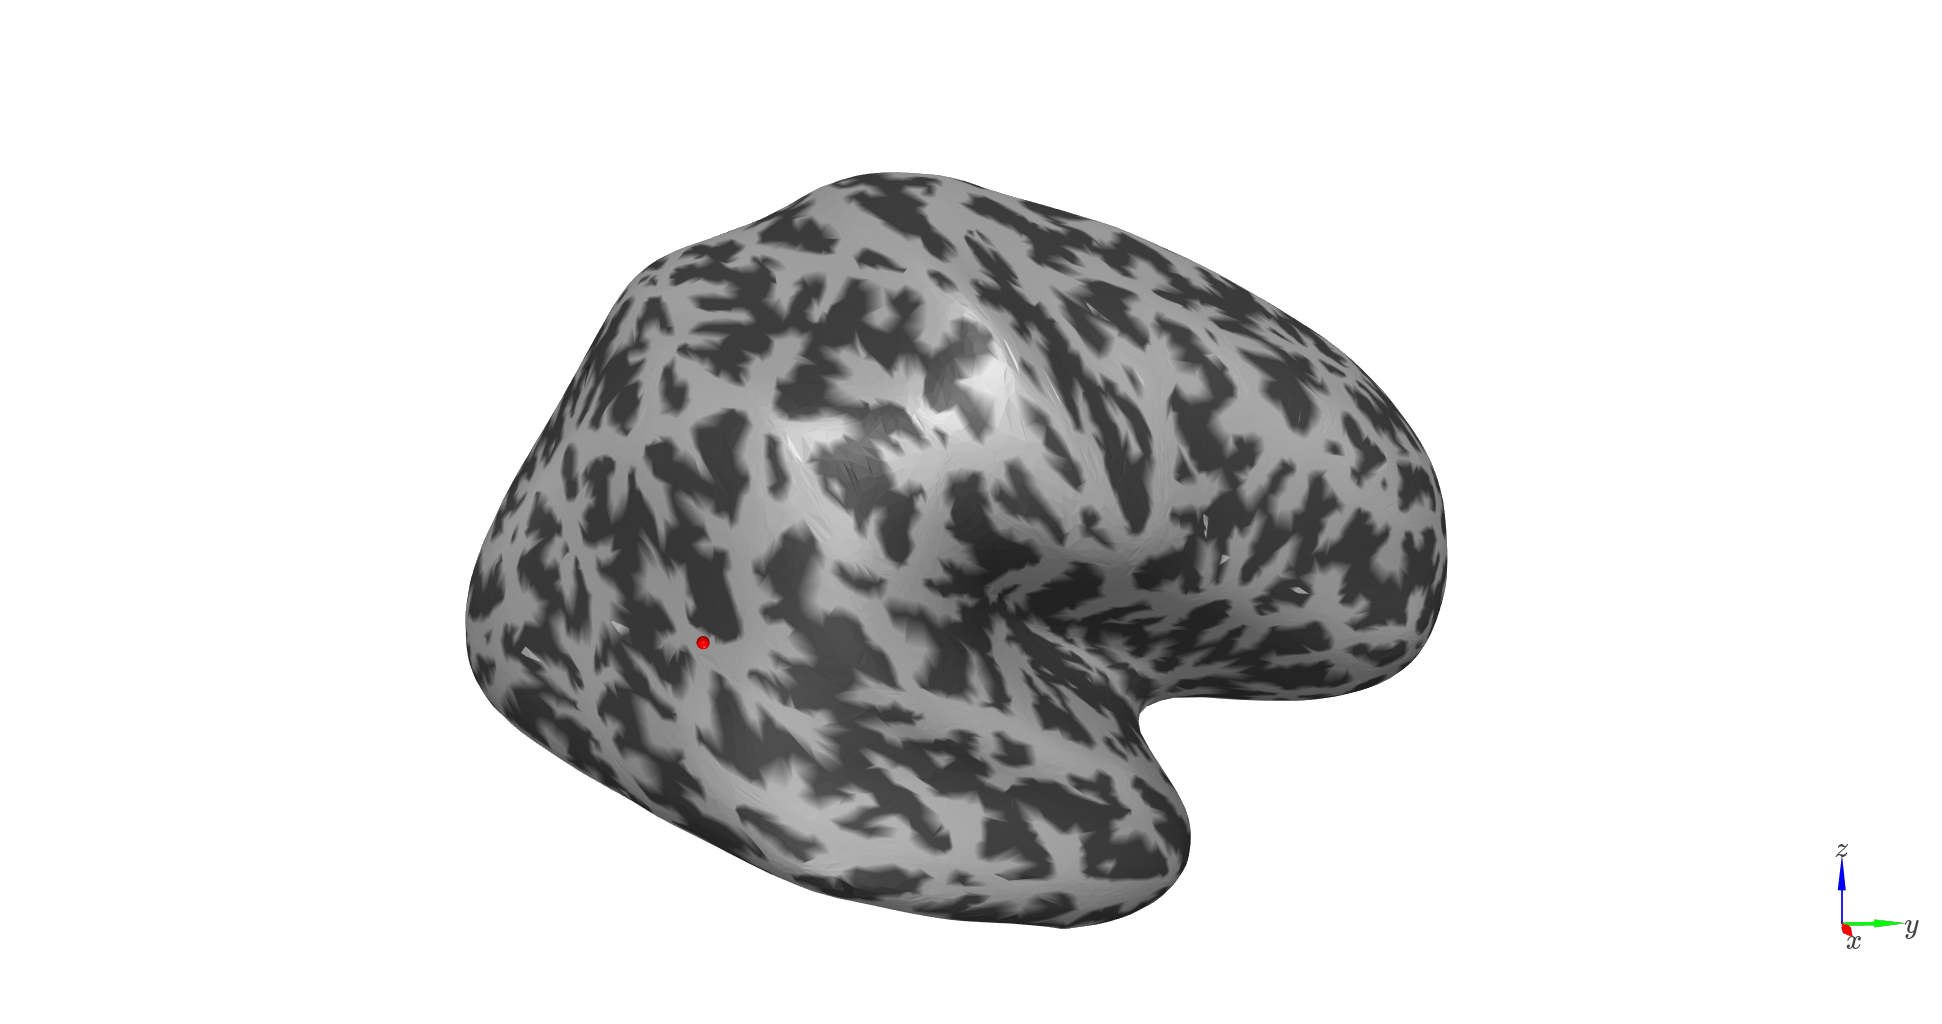

In [7]:
Image(data=base64.b64decode(plot.screenshot))

We'll simulate a 5mm patch of activity with -5 dB SNR at the sensor level. The desired level of SNR is achieved by adding white noise to the projected sensor signals

In [11]:
# Simulate at a vertex on the pial surface
pial_vertex = surf_set.get_multilayer_vertex('pial', sim_vertex)
prefix = f'sim_{sim_vertex}_pial_'

# Size of simulated patch of activity (mm)
sim_patch_size = 5
# SNR of simulated data (dB)
SNR = -5

# Generate simulated data
pial_sim_fname = run_current_density_simulation(
    base_fname, 
    prefix, 
    pial_vertex, 
    sim_signal, 
    dipole_moment, 
    sim_patch_size, 
    SNR,
    spm_instance=spm
)   

Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix:  - done
Saving prior in directory /home/bonaiuto/tmp/tmp8w2ax04x/simprior_sim_50492_pial_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 509.94 pAm/mm2, peak momemnt density 1398.13 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment density 509.94, sd 0.00 pAm/mm2
Prior 1. Average Peak (max vertex) moment density 1398.13, sd 0.00 pAm/mm2
Saving /home/bonaiuto/tmp/tmp8w2ax04x/simprior_sim_50492_pial_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo/prior331073.mat
Setting white noise to give sensor level SNR of -5B
Assembling 1 prior components
end assemble

 Finish


## Model comparison (pial - white matter)
Now we can run model comparison between source models based on the pial and white matter surfaces using cross-validation error. For computing cross-validation error, we'll run 10 folds, leaving out 10% of the channels in each fold. We'll then look at the difference in cross-validation error between the two models (pial - white matter). This should be lower for the pial surface model because we simulated activity on the pial surface

In [12]:
# Number of cross validation folds
n_folds = 10
# Percentage of test channels in cross validation
ideal_pc_test = 10 # may not use this number as we need integer number of channels

# Run model comparison between the first layer (pial) and the last layer (white matter)
[_,cvErr] = model_comparison(
    fid_coords, 
    pial_sim_fname, 
    surf_set_bilam,
    spm_instance=spm,
    invert_kwargs={
        'patch_size': patch_size, 
        'n_temp_modes': n_temp_modes, 
        'n_folds': n_folds, 
        'ideal_pc_test': ideal_pc_test    
    }
)

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Oct-2025 10:47:03 - Running job #1
------------------------------------------------------------------------
27-Oct-2025 10:47:03 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           10:47:19 - 27/10/2025
pial.ds.link_vector.fixed
undoing the G3BR balancing for the gradiometer definition
creating layout from cfg.grad
undoing the G3BR balancing for the gradiometer definition
creating lay

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.27 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.899051e+04 [+4.12]
  ReML Iteration 2                      :        ...2.806368e+04 [+4.25]
  ReML Iteration 3                      :        ...2.604212e+04 [+4.38]
  ReML Iteration 4                      :        ...2.183060e+04 [+4.50]
  ReML Iteration 5                      :        ...7.223183e+02 [+4.62]
  ReML Iteration 6                      :        ...6.662535e+00 [+4.75]
  ReML Iteration 7                      :        ...5.503524e-01 [+4.88]
  ReML Iteration 8                      :        ...5.826091e-02 [+5.00]
  ReML Iteration 9                      :        ...5.762440e-03 [+5.12]
Inverting subject 1
  ReML Iteration 1                      :        ...2.899051e+04 [+4.12]
  ReML Iteration 2                     

  ReML Iteration 1                      :        ...2.890089e+04 [+4.12]
  ReML Iteration 2                      :        ...2.782426e+04 [+4.25]
  ReML Iteration 3                      :        ...2.548323e+04 [+4.38]
  ReML Iteration 4                      :        ...2.073831e+04 [+4.50]
  ReML Iteration 5                      :        ...5.863760e+02 [+4.62]
  ReML Iteration 6                      :        ...8.214612e+00 [+4.75]
  ReML Iteration 7                      :        ...3.063052e-01 [+4.88]
  ReML Iteration 8                      :        ...1.642109e-02 [+5.00]
  ReML Iteration 9                      :        ...8.249050e-04 [+5.12]
Inverting subject 1
  ReML Iteration 1                      :        ...2.890089e+04 [+4.12]
  ReML Iteration 2                      :        ...2.782426e+04 [+4.25]
  ReML Iteration 3                      :        ...2.548323e+04 [+4.38]
  ReML Iteration 4                      :        ...2.073831e+04 [+4.50]
  ReML Iteration 5             

  ReML Iteration 7                      :        ...4.937485e-01 [+4.88]
  ReML Iteration 8                      :        ...4.756121e-02 [+5.00]
  ReML Iteration 9                      :        ...4.300446e-03 [+5.12]
Percent variance explained 99.99 (59.14)
       priors: []
         type: 'EBB'
          woi: [-500 500]
          Han: 0
          lpf: 0
          hpf: 256
    mergeflag: 0
           Np: 512
           Nm: 247
           Nt: 4
       smooth: 5
     modality: 'MEG'
         allF: 0
      PostMax: [51091x1 double]
            A: [247x247 double]
           Ip: [1x512 double]
            M: [51091x247 double]
            J: {[51091x4 double]}
            L: [247x51091 double]
           qC: [51091x1 double]
        tempU: [513x513 double]
            V: [513x4 double]
           qV: [601x601 double]
            T: [601x4 double]
            U: {[247x247 double]}
           Is: [1x51091 double]
           It: [1x601 double]
           Ik: [1x60 double]
           Ic: {[1

model evidences relative to maximum:

ans =

     0

       priors: []
         type: 'EBB'
          woi: [-500 500]
          Han: 0
          lpf: 0
          hpf: 256
    mergeflag: 0
           Np: 512
           Nm: 247
           Nt: 4
       smooth: 5
     modality: 'MEG'
         allF: -2.8579e+05
      PostMax: [51091x1 double]
            A: [247x247 double]
           Ip: [1x512 double]
            M: [51091x247 double]
            J: {[51091x4 double]}
            L: [247x51091 double]
           qC: [51091x1 double]
        tempU: [513x513 double]
            V: [513x4 double]
           qV: [601x601 double]
            T: [601x4 double]
            U: {[247x247 double]}
           Is: [1x51091 double]
           It: [1x601 double]
           Ik: [1x60 double]
           Ic: {[1x247 double]}
           Nd: 51091
          pst: [1x601 double]
          dct: [1x513 double]
           ID: 590.7754
            F: -2.8579e+05
           R2: 99.9852
           VE: 58.8064


 Cr


 Cross val iteration 10 of 10, first two chans:156, 42..
Running cross val..27-Oct-2025 10:51:26 - Done    'Source inversion, iterative'
27-Oct-2025 10:51:26 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Oct-2025 10:51:31 - Running job #1
------------------------------------------------------------------------
27-Oct-2025 10:51:31 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           10:51:33 - 27/10/2025
white.ds.link_vec

Using 4 temporal modes, accounting for 57.19 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.748126e+04 [+4.12]
  ReML Iteration 2                      :        ...2.565948e+04 [+4.25]
  ReML Iteration 3                      :        ...2.295977e+04 [+4.38]
  ReML Iteration 4                      :        ...1.840206e+04 [+4.50]
  ReML Iteration 5                      :        ...4.530207e+01 [+4.62]
  ReML Iteration 6                      :        ...5.639340e-02 [+4.75]
  ReML Iteration 7                      :        ...7.712979e-06 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...2.748126e+04 [+4.12]
  ReML Iteration 2                      :        ...2.565948e+04 [+4.25]
  ReML Iteration 3                      :        ...2.295977e+04 [+4.38]
  ReML Iteration 4                      :        ...1.840206e+04 [+4.50]
  ReML Iteration 5                      : 

  ReML Iteration 4                      :        ...1.852267e+04 [+4.50]
  ReML Iteration 5                      :        ...4.851209e+01 [+4.62]
  ReML Iteration 6                      :        ...8.791763e-03 [+4.75]
Percent variance explained 99.97 (58.81)
       priors: []
         type: 'EBB'
          woi: [-500 500]
          Han: 0
          lpf: 0
          hpf: 256
    mergeflag: 0
           Np: 512
           Nm: 247
           Nt: 4
       smooth: 5
     modality: 'MEG'
         allF: 0
      PostMax: [51091x1 double]
            A: [247x247 double]
           Ip: [1x512 double]
            M: [51091x247 double]
            J: {[51091x4 double]}
            L: [247x51091 double]
           qC: [51091x1 double]
        tempU: [513x513 double]
            V: [513x4 double]
           qV: [601x601 double]
            T: [601x4 double]
            U: {[247x247 double]}
           Is: [1x51091 double]
           It: [1x601 double]
           Ik: [1x60 double]
           Ic: {[1

model evidences relative to maximum:

ans =

     0

       priors: []
         type: 'EBB'
          woi: [-500 500]
          Han: 0
          lpf: 0
          hpf: 256
    mergeflag: 0
           Np: 512
           Nm: 247
           Nt: 4
       smooth: 5
     modality: 'MEG'
         allF: -3.0274e+05
      PostMax: [51091x1 double]
            A: [247x247 double]
           Ip: [1x512 double]
            M: [51091x247 double]
            J: {[51091x4 double]}
            L: [247x51091 double]
           qC: [51091x1 double]
        tempU: [513x513 double]
            V: [513x4 double]
           qV: [601x601 double]
            T: [601x4 double]
            U: {[247x247 double]}
           Is: [1x51091 double]
           It: [1x601 double]
           Ik: [1x60 double]
           Ic: {[1x247 double]}
           Nd: 51091
          pst: [1x601 double]
          dct: [1x513 double]
           ID: 571.9815
            F: -3.0274e+05
           R2: 99.9748
           VE: 56.2476


 Cr


 Cross val iteration 8 of 10, first two chans:210, 45..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.75 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.710566e+04 [+4.12]
  ReML Iteration 2                      :        ...2.528773e+04 [+4.25]
  ReML Iteration 3                      :        ...2.273089e+04 [+4.38]
  ReML Iteration 4                      :        ...1.850136e+04 [+4.50]
  ReML Iteration 5      

In [13]:
# The difference in cross validation error after averaging over test channels and folds
# This value should be negative (less error for the pial layer model)
np.mean(np.mean(cvErr[0],axis=-1),axis=-1)-np.mean(np.mean(cvErr[1],axis=-1),axis=-1)

-3.8249496458174193

## White matter surface simulation with pial - white matter model comparison
Let's simulate the same pattern of activity, in the same location, but on the white matter surface. This time, model comparison should yield lower cross-validation error for the white matter surface.

In [14]:
# Simulate at the corresponding vertex on the white matter surface
white_vertex = surf_set.get_multilayer_vertex('white', sim_vertex)
prefix = f'sim_{sim_vertex}_white_'

# Generate simulated data
white_sim_fname = run_current_density_simulation(
    base_fname, 
    prefix, 
    white_vertex, 
    sim_signal, 
    dipole_moment, 
    sim_patch_size, 
    SNR,
    spm_instance=spm
) 

# Run model comparison between the first layer (pial) and the last layer (white matter)
[_,cvErr] = model_comparison(
    fid_coords, 
    white_sim_fname, 
    surf_set_bilam,
    spm_instance=spm,
    invert_kwargs={
        'patch_size': patch_size, 
        'n_temp_modes': n_temp_modes, 
        'n_folds': n_folds, 
        'ideal_pc_test': ideal_pc_test    
    }
)

Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix:  - done
Saving prior in directory /home/bonaiuto/tmp/tmp8w2ax04x/simprior_sim_50492_white_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 509.72 pAm/mm2, peak momemnt density 1520.26 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment density 509.72, sd 0.00 pAm/mm2
Prior 1. Average Peak (max vertex) moment density 1520.26, sd 0.00 pAm/mm2
Saving /home/bonaiuto/tmp/tmp8w2ax04x/simprior_sim_50492_white_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo/prior616366.mat
Setting white noise to give sensor level SNR of -5B
Assembling 1 prior components
end assemble

 Finish
SPM, version dev (standalone)


 Cross val iteration 1 of 10, first two chans:188, 25..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.64 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.785798e+04 [+4.12]
  ReML Iteration 2                      :        ...2.628191e+04 [+4.25]
  ReML Iteration 3                      :        ...2.371856e+04 [+4.38]
  ReML Iteration 4                      :        ...1.899910e+04 [+4.50]
  ReML Iteration 5       

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.89 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.831070e+04 [+4.12]
  ReML Iteration 2                      :        ...2.684603e+04 [+4.25]
  ReML Iteration 3                      :        ...2.430077e+04 [+4.38]
  ReML Iteration 4                      :        ...1.958952e+04 [+4.50]
  ReML Iteration 5                      :        ...5.681153e+02 [+4.62]
  ReML Iteration 6                      :        ...3.263057e+00 [+4.75]
  ReML Iteration 7                      :        ...6.334055e-02 [+4.88]
  ReML Iteration 8                      :        ...1.537356e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.831070e+04 [+4.12]
  ReML Iteration 2                      :        ...2.684603e+04 [+4.25]
  ReML Iteration 3                     

model evidences relative to maximum:

ans =

     0

       priors: []
         type: 'EBB'
          woi: [-500 500]
          Han: 0
          lpf: 0
          hpf: 256
    mergeflag: 0
           Np: 512
           Nm: 247
           Nt: 4
       smooth: 5
     modality: 'MEG'
         allF: -2.8266e+05
      PostMax: [51091x1 double]
            A: [247x247 double]
           Ip: [1x512 double]
            M: [51091x247 double]
            J: {[51091x4 double]}
            L: [247x51091 double]
           qC: [51091x1 double]
        tempU: [513x513 double]
            V: [513x4 double]
           qV: [601x601 double]
            T: [601x4 double]
            U: {[247x247 double]}
           Is: [1x51091 double]
           It: [1x601 double]
           Ik: [1x60 double]
           Ic: {[1x247 double]}
           Nd: 51091
          pst: [1x601 double]
          dct: [1x513 double]
           ID: 419.4259
            F: -2.8266e+05
           R2: 99.9819
           VE: 51.8046


 Cr


 Cross val iteration 8 of 10, first two chans:209, 44..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.84 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.795574e+04 [+4.12]
  ReML Iteration 2                      :        ...2.642552e+04 [+4.25]
  ReML Iteration 3                      :        ...2.398981e+04 [+4.38]
  ReML Iteration 4                      :        ...1.955309e+04 [+4.50]
  ReML Iteration 5       



------------------------------------------------------------------------
27-Oct-2025 11:05:47 - Running job #1
------------------------------------------------------------------------
27-Oct-2025 11:05:47 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           11:05:49 - 27/10/2025
white.ds.link_vector.fixed
undoing the G3BR balancing for the gradiometer definition
creating layout from cfg.grad
undoing the G3BR balancing for the gradiometer definition
creating layout for ctf275 system

SPM: spm_eeg_inv_forward                           11:06:27 - 27/10/2025
Completed                               :          11:06:28 - 27/10/2025
computing surface normals
27-Oct-2025 11:06:30 - Done    'Head model specification'
27-Oct-2025 11:06:30 - Done

Smoothing ../test_data/fs/sub-104/surf/laminar/white.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_white.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/

  ReML Iteration 8                      :        ...7.245827e-03 [+5.00]
Percent variance explained 99.99 (55.33)
       priors: []
         type: 'EBB'
          woi: [-500 500]
          Han: 0
          lpf: 0
          hpf: 256
    mergeflag: 0
           Np: 512
           Nm: 247
           Nt: 4
       smooth: 5
     modality: 'MEG'
         allF: 0
      PostMax: [51091x1 double]
            A: [247x247 double]
           Ip: [1x512 double]
            M: [51091x247 double]
            J: {[51091x4 double]}
            L: [247x51091 double]
           qC: [51091x1 double]
        tempU: [513x513 double]
            V: [513x4 double]
           qV: [601x601 double]
            T: [601x4 double]
            U: {[247x247 double]}
           Is: [1x51091 double]
           It: [1x601 double]
           Ik: [1x60 double]
           Ic: {[1x247 double]}
           Nd: 51091
          pst: [1x601 double]
          dct: [1x513 double]
           ID: 430.8810
            F: -2.7197e+05


model evidences relative to maximum:

ans =

     0

       priors: []
         type: 'EBB'
          woi: [-500 500]
          Han: 0
          lpf: 0
          hpf: 256
    mergeflag: 0
           Np: 512
           Nm: 247
           Nt: 4
       smooth: 5
     modality: 'MEG'
         allF: -2.7047e+05
      PostMax: [51091x1 double]
            A: [247x247 double]
           Ip: [1x512 double]
            M: [51091x247 double]
            J: {[51091x4 double]}
            L: [247x51091 double]
           qC: [51091x1 double]
        tempU: [513x513 double]
            V: [513x4 double]
           qV: [601x601 double]
            T: [601x4 double]
            U: {[247x247 double]}
           Is: [1x51091 double]
           It: [1x601 double]
           Ik: [1x60 double]
           Ic: {[1x247 double]}
           Nd: 51091
          pst: [1x601 double]
          dct: [1x513 double]
           ID: 440.8345
            F: -2.7047e+05
           R2: 99.9866
           VE: 56.6847


 Cr


 Cross val iteration 6 of 10, first two chans:157, 225..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 49.98 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.870612e+04 [+4.12]
  ReML Iteration 2                      :        ...2.736111e+04 [+4.25]
  ReML Iteration 3                      :        ...2.450977e+04 [+4.38]
  ReML Iteration 4                      :        ...1.898108e+04 [+4.50]
  ReML Iteration 5     

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.82 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.890571e+04 [+4.12]
  ReML Iteration 2                      :        ...2.785413e+04 [+4.25]
  ReML Iteration 3                      :        ...2.562780e+04 [+4.38]
  ReML Iteration 4                      :        ...2.118723e+04 [+4.50]
  ReML Iteration 5                      :        ...6.879240e+02 [+4.62]
  ReML Iteration 6                      :        ...5.572846e+00 [+4.75]
  ReML Iteration 7                      :        ...3.095331e-01 [+4.88]
  ReML Iteration 8                      :        ...2.181045e-02 [+5.00]
  ReML Iteration 9                      :        ...1.456936e-03 [+5.12]
Inverting subject 1
  ReML Iteration 1                      :        ...2.890571e+04 [+4.12]
  ReML Iteration 2                     

In [15]:
# The difference in cross validation error after averaging over test channels and folds
# This value should be positive (less error for the white matter layer model)
np.mean(np.mean(cvErr[0],axis=-1),axis=-1)-np.mean(np.mean(cvErr[1],axis=-1),axis=-1)

1.3223821691885433

## Simulation in each layer with model comparison across layers
That was model comparison with two candidate models: one based on the white matter surface, and one on the pial. Let's now simulate on each layer, and for each simulation, run model comparison across all layers. We'll turn off SPM visualization here.

In [17]:
# Now simulate at the corresponding vertex on each layer, and for each simulation, run model comparison across
# all layers
all_layerCvErr = []

for l in range(surf_set.n_layers):
    print(f'Simulating in layer {l}')
    l_vertex = surf_set.get_multilayer_vertex(l, sim_vertex)
    prefix = f'sim_{sim_vertex}_{l}_'

    l_sim_fname = run_current_density_simulation(
        base_fname, 
        prefix, 
        l_vertex, 
        sim_signal, 
        dipole_moment, 
        sim_patch_size, 
        SNR,
        spm_instance=spm
    ) 

    [_,layerCvErr] = model_comparison(
        fid_coords, 
        l_sim_fname, 
        surf_set,
        viz=False,
        spm_instance=spm,
        invert_kwargs={
            'patch_size': patch_size, 
            'n_temp_modes': n_temp_modes, 
            'n_folds': n_folds, 
            'ideal_pc_test': ideal_pc_test    
        }
    )
    all_layerCvErr.append(layerCvErr)    
all_layerCvErr = np.array(all_layerCvErr)

# Average over test channels and folds
all_layerCvErr = np.mean(np.mean(all_layerCvErr, axis=-1), axis=-1)

Simulating in layer 0
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /home/bonaiuto/tmp/tmp8w2ax04x/simprior_sim_50492_0_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 509.94 pAm/mm2, peak momemnt density 1398.13 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment density 509.94, sd 0.00 pAm/mm2
Prior 1. Average Peak (max vertex) moment density 1398.13, sd 0.00 pAm/mm2
Saving /home/bonaiuto/tmp/tmp8w2ax04x/simprior_sim_50

  ReML Iteration 1                      :        ...2.892018e+04 [+4.12]
  ReML Iteration 2                      :        ...2.787989e+04 [+4.25]
  ReML Iteration 3                      :        ...2.565332e+04 [+4.38]
  ReML Iteration 4                      :        ...2.118440e+04 [+4.50]
  ReML Iteration 5                      :        ...6.941095e+02 [+4.62]
  ReML Iteration 6                      :        ...7.347803e+00 [+4.75]
  ReML Iteration 7                      :        ...3.827759e-01 [+4.88]
  ReML Iteration 8                      :        ...2.651174e-02 [+5.00]
  ReML Iteration 9                      :        ...1.727055e-03 [+5.12]
Percent variance explained 99.99 (57.49)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 2 of 10, first two chans:179, 29..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

  ReML Iteration 1                      :        ...2.882632e+04 [+4.12]
  ReML Iteration 2                      :        ...2.764336e+04 [+4.25]
  ReML Iteration 3                      :        ...2.510404e+04 [+4.38]
  ReML Iteration 4                      :        ...2.007480e+04 [+4.50]
  ReML Iteration 5                      :        ...1.201663e+04 [+4.62]
  ReML Iteration 6                      :        ...1.495441e+02 [+4.75]
  ReML Iteration 7                      :        ...5.965548e-02 [+4.88]
  ReML Iteration 8                      :        ...1.698017e-03 [+5.00]
Percent variance explained 99.98 (53.43)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 6 of 10, first two chans:146, 156..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/su

  ReML Iteration 1                      :        ...2.894155e+04 [+4.12]
  ReML Iteration 2                      :        ...2.793607e+04 [+4.25]
  ReML Iteration 3                      :        ...2.577986e+04 [+4.38]
  ReML Iteration 4                      :        ...2.141467e+04 [+4.50]
  ReML Iteration 5                      :        ...7.663988e+02 [+4.62]
  ReML Iteration 6                      :        ...6.787887e+00 [+4.75]
  ReML Iteration 7                      :        ...4.827821e-01 [+4.88]
  ReML Iteration 8                      :        ...4.381199e-02 [+5.00]
  ReML Iteration 9                      :        ...3.737394e-03 [+5.12]
Percent variance explained 99.99 (58.35)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 10 of 10, first two chans:150, 17..
Running cross val..27-Oct-2025 12:17:35 - Done    'Source inversion, iterative'
27-Oct-2025 12:17:35 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___

model evidences relative to maximum:

ans =

     0


 Cross val iteration 2 of 10, first two chans:180, 30..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.92 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.892595e+04 [+4.12]
  ReML Iteration 2                      :        ...2.790444e+04 [+4.25]
  ReML Iteration 3                      :        ...2.574607e+04 [+4.38]
  ReML Iteration 4                      :   


 Cross val iteration 6 of 10, first two chans:157, 225..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.31 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.871909e+04 [+4.12]
  ReML Iteration 2                      :        ...2.740374e+04 [+4.25]
  ReML Iteration 3                      :        ...2.464735e+04 [+4.38]
  ReML Iteration 4                      :        ...1.932523e+04 [+4.50]
  ReML Iteration 5     

Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.92 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.875078e+04 [+4.12]
  ReML Iteration 2                      :        ...2.756735e+04 [+4.25]
  ReML Iteration 3                      :        ...2.526422e+04 [+4.38]
  ReML Iteration 4                      :        ...2.091181e+04 [+4.50]
  ReML Iteration 5                      :        ...6.801369e+02 [+4.62]
  ReML Iteration 6                      :        ...3.513302e+00 [+4.75]
  ReML Iteration 7                      :        ...1.435525e-01 [+4.88]
  ReML Iteration 8                      :        ...7.074620e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.875078e+04 [+4.12]
  ReML Iteration 2                      :        ...2.756735e+04 [+4.25]
  ReML Iteration 3                      :        ...2.526422e+04 [+4.38]
  ReML Iter

  ReML Iteration 1                      :        ...2.847178e+04 [+4.12]
  ReML Iteration 2                      :        ...2.697437e+04 [+4.25]
  ReML Iteration 3                      :        ...2.411486e+04 [+4.38]
  ReML Iteration 4                      :        ...1.880059e+04 [+4.50]
  ReML Iteration 5                      :        ...1.067337e+04 [+4.62]
  ReML Iteration 6                      :        ...8.989954e+01 [+4.75]
  ReML Iteration 7                      :        ...5.320875e-05 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...2.847178e+04 [+4.12]
  ReML Iteration 2                      :        ...2.697437e+04 [+4.25]
  ReML Iteration 3                      :        ...2.411486e+04 [+4.38]
  ReML Iteration 4                      :        ...1.880059e+04 [+4.50]
  ReML Iteration 5                      :        ...1.067337e+04 [+4.62]
  ReML Iteration 6                      :        ...8.989954e+01 [+4.75]
  ReML Iteration 7             


SPM: spm_eeg_inv_forward                           12:26:16 - 27/10/2025
Completed                               :          12:26:16 - 27/10/2025
27-Oct-2025 12:26:17 - Done    'Head model specification'
27-Oct-2025 12:26:17 - Done

Smoothing ../test_data/fs/sub-104/surf/laminar/0.700.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.700.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      12:26:18 - 27/10/2025
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 10 for 247 training and 27 test chans

Preparing modes file  block 2 of 10 for 247 training and 27 test chans

Preparing modes fi


 Cross val iteration 3 of 10, first two chans:178, 173..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.81 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.850999e+04 [+4.12]
  ReML Iteration 2                      :        ...2.717742e+04 [+4.25]
  ReML Iteration 3                      :        ...2.480714e+04 [+4.38]
  ReML Iteration 4                      :        ...2.044466e+04 [+4.50]
  ReML Iteration 5     

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.17 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.810816e+04 [+4.12]
  ReML Iteration 2                      :        ...2.656332e+04 [+4.25]
  ReML Iteration 3                      :        ...2.404137e+04 [+4.38]
  ReML Iteration 4                      :        ...1.950120e+04 [+4.50]
  ReML Iteration 5                      :        ...4.291126e+02 [+4.62]
  ReML Iteration 6                      :        ...1.187191e+00 [+4.75]
  ReML Iteration 7                      :        ...1.750541e-02 [+4.88]
  ReML Iteration 8                      :        ...2.987486e-04 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.810816e+04 [+4.12]
  ReML Iteration 2                      :        ...2.656332e+04 [+4.25]
  ReML Iteration 3                     

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Oct-2025 12:31:04 - Running job #2
------------------------------------------------------------------------
27-Oct-2025 12:31:04 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_50492_0_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generatin


 Cross val iteration 4 of 10, first two chans:133, 102..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.46 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.801854e+04 [+4.12]
  ReML Iteration 2                      :        ...2.649127e+04 [+4.25]
  ReML Iteration 3                      :        ...2.399444e+04 [+4.38]
  ReML Iteration 4                      :        ...1.947919e+04 [+4.50]
  ReML Iteration 5     

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.72 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.829728e+04 [+4.12]
  ReML Iteration 2                      :        ...2.685782e+04 [+4.25]
  ReML Iteration 3                      :        ...2.446924e+04 [+4.38]
  ReML Iteration 4                      :        ...2.020022e+04 [+4.50]
  ReML Iteration 5                      :        ...4.645603e+02 [+4.62]
  ReML Iteration 6                      :        ...7.126089e-01 [+4.75]
  ReML Iteration 7                      :        ...1.547587e-02 [+4.88]
  ReML Iteration 8                      :        ...3.703773e-04 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.829728e+04 [+4.12]
  ReML Iteration 2                      :        ...2.685782e+04 [+4.25]
  ReML Iteration 3                     

  ReML Iteration 1                      :        ...2.798792e+04 [+4.12]
  ReML Iteration 2                      :        ...2.642665e+04 [+4.25]
  ReML Iteration 3                      :        ...2.398165e+04 [+4.38]
  ReML Iteration 4                      :        ...1.967234e+04 [+4.50]
  ReML Iteration 5                      :        ...3.130551e+02 [+4.62]
  ReML Iteration 6                      :        ...3.220647e-01 [+4.75]
  ReML Iteration 7                      :        ...3.788804e-03 [+4.88]
Percent variance explained 99.98 (59.25)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 1 of 10, first two chans:189, 26..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - don

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.24 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.785124e+04 [+4.12]
  ReML Iteration 2                      :        ...2.620438e+04 [+4.25]
  ReML Iteration 3                      :        ...2.361354e+04 [+4.38]
  ReML Iteration 4                      :        ...1.899864e+04 [+4.50]
  ReML Iteration 5                      :        ...2.846781e+02 [+4.62]
  ReML I

  ReML Iteration 1                      :        ...2.778963e+04 [+4.12]
  ReML Iteration 2                      :        ...2.609235e+04 [+4.25]
  ReML Iteration 3                      :        ...2.347194e+04 [+4.38]
  ReML Iteration 4                      :        ...1.893009e+04 [+4.50]
  ReML Iteration 5                      :        ...1.867895e+02 [+4.62]
  ReML Iteration 6                      :        ...2.295716e-01 [+4.75]
  ReML Iteration 7                      :        ...1.060550e-03 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...2.778963e+04 [+4.12]
  ReML Iteration 2                      :        ...2.609235e+04 [+4.25]
  ReML Iteration 3                      :        ...2.347194e+04 [+4.38]
  ReML Iteration 4                      :        ...1.893009e+04 [+4.50]
  ReML Iteration 5                      :        ...1.867895e+02 [+4.62]
  ReML Iteration 6                      :        ...2.295716e-01 [+4.75]
  ReML Iteration 7             

model evidences relative to maximum:

ans =

     0


 Cross val iteration 2 of 10, first two chans:180, 30..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.92 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.797025e+04 [+4.12]
  ReML Iteration 2                      :        ...2.637675e+04 [+4.25]
  ReML Iteration 3                      :        ...2.387496e+04 [+4.38]
  ReML Iteration 4                      :   

  ReML Iteration 1                      :        ...2.760451e+04 [+4.12]
  ReML Iteration 2                      :        ...2.574263e+04 [+4.25]
  ReML Iteration 3                      :        ...2.276985e+04 [+4.38]
  ReML Iteration 4                      :        ...1.754213e+04 [+4.50]
  ReML Iteration 5                      :        ...9.829149e+03 [+4.62]
  ReML Iteration 6                      :        ...7.189630e+00 [+4.75]
  ReML Iteration 7                      :        ...2.115373e-03 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...2.760451e+04 [+4.12]
  ReML Iteration 2                      :        ...2.574263e+04 [+4.25]
  ReML Iteration 3                      :        ...2.276985e+04 [+4.38]
  ReML Iteration 4                      :        ...1.754213e+04 [+4.50]
  ReML Iteration 5                      :        ...9.829149e+03 [+4.62]
  ReML Iteration 6                      :        ...7.189630e+00 [+4.75]
  ReML Iteration 7             

Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      12:42:45 - 27/10/2025
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 10 for 247 training and 27 test chans

Preparing modes file  block 2 of 10 for 247 training and 27 test chans

Preparing modes file  block 3 of 10 for 247 training and 27 test chans

Preparing modes file  block 4 of 10 for 247 training and 27 test chans

Preparing modes file  block 5 of 10 for 247 training and 27 test chans

Preparing modes file  block 6 of 10 for 247 training and 27 test chans

Preparing modes file  block 7 of 10 for 247 training and 27 test chans

Preparing modes file  block 8 of 10 for 247 training and 27 test chans

Preparing modes file  block 9 of 10 for 247 training and 27 test chans

Preparing modes file  block 10 of 10 for 

  ReML Iteration 1                      :        ...2.728309e+04 [+4.12]
  ReML Iteration 2                      :        ...2.550078e+04 [+4.25]
  ReML Iteration 3                      :        ...2.289112e+04 [+4.38]
  ReML Iteration 4                      :        ...1.838381e+04 [+4.50]
  ReML Iteration 5                      :        ...1.001922e+02 [+4.62]
  ReML Iteration 6                      :        ...1.360502e-01 [+4.75]
  ReML Iteration 7                      :        ...1.483131e-04 [+4.88]
Percent variance explained 99.97 (57.16)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 8 of 10, first two chans:210, 45..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - don

Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.26 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.761636e+04 [+4.12]
  ReML Iteration 2                      :        ...2.591693e+04 [+4.25]
  ReML Iteration 3                      :        ...2.339449e+04 [+4.38]
  ReML Iteration 4                      :        ...1.908080e+04 [+4.50]
  ReML Iteration 5                      :        ...1.258220e+02 [+4.62]
  ReML Iteration 6                      :        ...5.499394e-02 [+4.75]
  ReML Iteration 7                      :        ...1.97468

  ReML Iteration 1                      :        ...2.744722e+04 [+4.12]
  ReML Iteration 2                      :        ...2.573817e+04 [+4.25]
  ReML Iteration 3                      :        ...2.311219e+04 [+4.38]
  ReML Iteration 4                      :        ...1.861000e+04 [+4.50]
  ReML Iteration 5                      :        ...8.785808e+01 [+4.62]
  ReML Iteration 6                      :        ...1.882818e-02 [+4.75]
  ReML Iteration 7                      :        ...5.080883e-05 [+4.88]
Percent variance explained 99.97 (57.44)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 5 of 10, first two chans:124, 229..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
 - do

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.03 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.746007e+04 [+4.12]
  ReML Iteration 2                      :        ...2.562751e+04 [+4.25]
  ReML Iteration 3                      :        ...2.292153e+04 [+4.38]
  ReML Iteration 4                      :        ...1.838802e+04 [+4.50]
  ReML Iteration 5                      :        ...4.983749e+01 [+4.62]
  ReML I

  ReML Iteration 1                      :        ...2.741108e+04 [+4.12]
  ReML Iteration 2                      :        ...2.563248e+04 [+4.25]
  ReML Iteration 3                      :        ...2.289640e+04 [+4.38]
  ReML Iteration 4                      :        ...1.825851e+04 [+4.50]
  ReML Iteration 5                      :        ...1.897179e+01 [+4.62]
  ReML Iteration 6                      :        ...1.578386e-02 [+4.75]
  ReML Iteration 7                      :        ...4.117242e-09 [+4.88]
Percent variance explained 99.97 (57.15)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 2 of 10, first two chans:180, 30..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - don

Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.31 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.719432e+04 [+4.12]
  ReML Iteration 2                      :        ...2.518536e+04 [+4.25]
  ReML Iteration 3                      :        ...2.214759e+04 [+4.38]
  ReML Iteration 4                      :        ...1.698308e+04 [+4.50]
  ReML Iteration 5                      :        ...9.513940e+03 [+4.62]
  ReML Iteration 6                      :        ...3.190622e+00 [+4.75]
  ReML Iteration 7                      :        ...2.16011

white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           12:54:46 - 27/10/2025
Completed                               :          12:54:46 - 27/10/2025
27-Oct-2025 12:54:47 - Done    'Head model specification'
27-Oct-2025 12:54:47 - Done

Smoothing ../test_data/fs/sub-104/surf/laminar/white.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_white.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      12:54:48 - 27/10/2025
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 10 for 247 training and 27 test chans

Preparing modes file  block 2 of 10 for 247 training and 27 tes


 Cross val iteration 3 of 10, first two chans:178, 173..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.81 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.709415e+04 [+4.12]
  ReML Iteration 2                      :        ...2.530431e+04 [+4.25]
  ReML Iteration 3                      :        ...2.270581e+04 [+4.38]
  ReML Iteration 4                      :        ...1.836153e+04 [+4.50]
  ReML Iteration 5     

  ReML Iteration 1                      :        ...2.689876e+04 [+4.12]
  ReML Iteration 2                      :        ...2.502256e+04 [+4.25]
  ReML Iteration 3                      :        ...2.236892e+04 [+4.38]
  ReML Iteration 4                      :        ...1.789168e+04 [+4.50]
  ReML Iteration 5                      :        ...1.656839e+01 [+4.62]
  ReML Iteration 6                      :        ...1.577074e-02 [+4.75]
  ReML Iteration 7                      :        ...3.083495e-07 [+4.88]
Percent variance explained 99.96 (57.15)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 8 of 10, first two chans:210, 45..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - don

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Oct-2025 13:05:03 - Running job #2
------------------------------------------------------------------------
27-Oct-2025 13:05:04 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_50492_1_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
U

  ReML Iteration 1                      :        ...2.869196e+04 [+4.12]
  ReML Iteration 2                      :        ...2.745391e+04 [+4.25]
  ReML Iteration 3                      :        ...2.508159e+04 [+4.38]
  ReML Iteration 4                      :        ...2.062170e+04 [+4.50]
  ReML Iteration 5                      :        ...7.042189e+02 [+4.62]
  ReML Iteration 6                      :        ...3.612022e+00 [+4.75]
  ReML Iteration 7                      :        ...1.476096e-01 [+4.88]
  ReML Iteration 8                      :        ...7.264828e-03 [+5.00]
Percent variance explained 99.99 (57.75)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 4 of 10, first two chans:132, 101..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/su

  ReML Iteration 1                      :        ...2.873330e+04 [+4.12]
  ReML Iteration 2                      :        ...2.751048e+04 [+4.25]
  ReML Iteration 3                      :        ...2.508549e+04 [+4.38]
  ReML Iteration 4                      :        ...2.045294e+04 [+4.50]
  ReML Iteration 5                      :        ...7.017092e+02 [+4.62]
  ReML Iteration 6                      :        ...5.148761e+00 [+4.75]
  ReML Iteration 7                      :        ...1.991143e-01 [+4.88]
  ReML Iteration 8                      :        ...9.734221e-03 [+5.00]
Percent variance explained 99.99 (56.53)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 8 of 10, first two chans:209, 44..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/sur



------------------------------------------------------------------------
27-Oct-2025 13:09:08 - Running job #2
------------------------------------------------------------------------
27-Oct-2025 13:09:08 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_50492_1_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.08 percent average variance
NB smooth EBB algorith

  ReML Iteration 1                      :        ...2.898001e+04 [+4.12]
  ReML Iteration 2                      :        ...2.803627e+04 [+4.25]
  ReML Iteration 3                      :        ...2.597448e+04 [+4.38]
  ReML Iteration 4                      :        ...2.168182e+04 [+4.50]
  ReML Iteration 5                      :        ...7.181023e+02 [+4.62]
  ReML Iteration 6                      :        ...6.783337e+00 [+4.75]
  ReML Iteration 7                      :        ...5.527505e-01 [+4.88]
  ReML Iteration 8                      :        ...5.793461e-02 [+5.00]
  ReML Iteration 9                      :        ...5.670699e-03 [+5.12]
Percent variance explained 99.99 (58.60)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 4 of 10, first two chans:133, 102..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.132

  ReML Iteration 1                      :        ...2.890675e+04 [+4.12]
  ReML Iteration 2                      :        ...2.784940e+04 [+4.25]
  ReML Iteration 3                      :        ...2.558719e+04 [+4.38]
  ReML Iteration 4                      :        ...2.104506e+04 [+4.50]
  ReML Iteration 5                      :        ...6.645614e+02 [+4.62]
  ReML Iteration 6                      :        ...6.679118e+00 [+4.75]
  ReML Iteration 7                      :        ...3.331508e-01 [+4.88]
  ReML Iteration 8                      :        ...2.193904e-02 [+5.00]
  ReML Iteration 9                      :        ...1.362532e-03 [+5.12]
Percent variance explained 99.99 (56.96)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 8 of 10, first two chans:210, 45..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321



------------------------------------------------------------------------
27-Oct-2025 13:13:13 - Running job #2
------------------------------------------------------------------------
27-Oct-2025 13:13:13 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_50492_1_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.08 percent average variance
NB smooth EBB algorith


 Cross val iteration 4 of 10, first two chans:133, 102..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.27 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.867140e+04 [+4.12]
  ReML Iteration 2                      :        ...2.741522e+04 [+4.25]
  ReML Iteration 3                      :        ...2.501092e+04 [+4.38]
  ReML Iteration 4                      :        ...2.048056e+04 [+4.50]
  ReML Iteration 5     

Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.08 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.853560e+04 [+4.12]
  ReML Iteration 2                      :        ...2.721326e+04 [+4.25]
  ReML Iteration 3                      :        ...2.485497e+04 [+4.38]
  ReML Iteration 4                      :        ...2.053460e+04 [+4.50]
  ReML Iteration 5                      :        ...6.289617e+02 [+4.62]
  ReML Iteration 6                      :        ...1.854809e+00 [+4.75]
  ReML Iteration 7                      :        ...6.33507

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.27 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.837381e+04 [+4.12]
  ReML Iteration 2                      :        ...2.695105e+04 [+4.25]
  ReML Iteration 3                      :        ...2.447712e+04 [+4.38]
  ReML Iteration 4                      :        ...1.994147e+04 [+4.50]
  ReML Iteration 5                      :        ...5.250118e+02 [+4.62]
  ReML Iteration 6                      :        ...1.731655e+00 [+4.75]
  ReML Iteration 7                      :        ...3.942443e-02 [+4.88]
  ReML Iteration 8                      :        ...1.046383e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.837381e+04 [+4.12]
  ReML Iteration 2                      :        ...2.695105e+04 [+4.25]
  ReML Iteration 3                     

  ReML Iteration 1                      :        ...2.893774e+04 [+4.12]
  ReML Iteration 2                      :        ...2.793672e+04 [+4.25]
  ReML Iteration 3                      :        ...2.582738e+04 [+4.38]
  ReML Iteration 4                      :        ...2.161719e+04 [+4.50]
  ReML Iteration 5                      :        ...7.645184e+02 [+4.62]
  ReML Iteration 6                      :        ...4.485481e+00 [+4.75]
  ReML Iteration 7                      :        ...3.245802e-01 [+4.88]
  ReML Iteration 8                      :        ...2.838261e-02 [+5.00]
  ReML Iteration 9                      :        ...2.363197e-03 [+5.12]
Percent variance explained 99.99 (59.54)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 9 of 10, first two chans:130, 224..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.132

model evidences relative to maximum:

ans =

     0


 Cross val iteration 1 of 10, first two chans:189, 26..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.01 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.837463e+04 [+4.12]
  ReML Iteration 2                      :        ...2.691921e+04 [+4.25]
  ReML Iteration 3                      :        ...2.438027e+04 [+4.38]
  ReML Iteration 4                      :   

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.07 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.823678e+04 [+4.12]
  ReML Iteration 2                      :        ...2.673933e+04 [+4.25]
  ReML Iteration 3                      :        ...2.419334e+04 [+4.38]
  ReML Iteration 4                      :        ...1.954233e+04 [+4.50]
  ReML Iteration 5                      :        ...4.482506e+02 [+4.62]
  ReML I

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.90 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.859066e+04 [+4.12]
  ReML Iteration 2                      :        ...2.725902e+04 [+4.25]
  ReML Iteration 3                      :        ...2.476920e+04 [+4.38]
  ReML Iteration 4                      :        ...2.016492e+04 [+4.50]
  ReML Iteration 5                      :        ...5.130681e+02 [+4.62]
  ReML Iteration 6                      :        ...2.192672e+00 [+4.75]
  ReML Iteration 7                      :        ...5.152355e-02 [+4.88]
  ReML Iteration 8                      :        ...1.449908e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.859066e+04 [+4.12]
  ReML Iteration 2                      :        ...2.725902e+04 [+4.25]
  ReML Iteration 3                     

  ReML Iteration 1                      :        ...2.823546e+04 [+4.12]
  ReML Iteration 2                      :        ...2.670620e+04 [+4.25]
  ReML Iteration 3                      :        ...2.412784e+04 [+4.38]
  ReML Iteration 4                      :        ...1.952306e+04 [+4.50]
  ReML Iteration 5                      :        ...3.406917e+02 [+4.62]
  ReML Iteration 6                      :        ...8.186320e-01 [+4.75]
  ReML Iteration 7                      :        ...9.407867e-03 [+4.88]
Percent variance explained 99.98 (57.00)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 2 of 10, first two chans:180, 30..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - don

model evidences relative to maximum:

ans =

     0


 Cross val iteration 6 of 10, first two chans:157, 225..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.15 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.758333e+04 [+4.12]
  ReML Iteration 2                      :        ...2.579030e+04 [+4.25]
  ReML Iteration 3                      :        ...2.287756e+04 [+4.38]
  ReML Iteration 4                      :  



------------------------------------------------------------------------
27-Oct-2025 13:28:15 - Running job #2
------------------------------------------------------------------------
27-Oct-2025 13:28:15 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           13:28:48 - 27/10/2025
Completed                               :          13:28:48 - 27/10/2025
27-Oct-2025 13:28:50 - Done    'Head model specification'
27-Oct-2025 13:28:50 - Done

Smoothing ../test_data/fs/sub-104/surf/laminar/0.400.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.400.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      13:28:50 - 27


 Cross val iteration 3 of 10, first two chans:178, 173..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.61 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.818881e+04 [+4.12]
  ReML Iteration 2                      :        ...2.665327e+04 [+4.25]
  ReML Iteration 3                      :        ...2.414464e+04 [+4.38]
  ReML Iteration 4                      :        ...1.972630e+04 [+4.50]
  ReML Iteration 5     

  ReML Iteration 1                      :        ...2.741218e+04 [+4.12]
  ReML Iteration 2                      :        ...2.573848e+04 [+4.25]
  ReML Iteration 3                      :        ...2.320340e+04 [+4.38]
  ReML Iteration 4                      :        ...1.871582e+04 [+4.50]
  ReML Iteration 5                      :        ...2.037784e+02 [+4.62]
  ReML Iteration 6                      :        ...1.907372e-01 [+4.75]
  ReML Iteration 7                      :        ...1.092626e-03 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...2.741218e+04 [+4.12]
  ReML Iteration 2                      :        ...2.573848e+04 [+4.25]
  ReML Iteration 3                      :        ...2.320340e+04 [+4.38]
  ReML Iteration 4                      :        ...1.871582e+04 [+4.50]
  ReML Iteration 5                      :        ...2.037784e+02 [+4.62]
  ReML Iteration 6                      :        ...1.907372e-01 [+4.75]
  ReML Iteration 7             



------------------------------------------------------------------------
27-Oct-2025 13:33:25 - Running job #2
------------------------------------------------------------------------
27-Oct-2025 13:33:25 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_50492_1_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.08 percent average variance
NB smooth EBB algorith

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.27 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.766355e+04 [+4.12]
  ReML Iteration 2                      :        ...2.597870e+04 [+4.25]
  ReML Iteration 3                      :        ...2.337988e+04 [+4.38]
  ReML Iteration 4                      :        ...1.884214e+04 [+4.50]
  ReML Iteration 5                      :        ...1.560151e+02 [+4.62]
  ReML Iteration 6                      :        ...1.748166e-01 [+4.75]
  ReML Iteration 7                      :        ...6.031700e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...2.766355e+04 [+4.12]
  ReML Iteration 2                      :        ...2.597870e+04 [+4.25]
  ReML Iteration 3                      :        ...2.337988e+04 [+4.38]
  ReML Iteration 4                     

  ReML Iteration 1                      :        ...2.837956e+04 [+4.12]
  ReML Iteration 2                      :        ...2.696289e+04 [+4.25]
  ReML Iteration 3                      :        ...2.456090e+04 [+4.38]
  ReML Iteration 4                      :        ...2.026565e+04 [+4.50]
  ReML Iteration 5                      :        ...4.189671e+02 [+4.62]
  ReML Iteration 6                      :        ...9.066943e-01 [+4.75]
  ReML Iteration 7                      :        ...1.616301e-02 [+4.88]
  ReML Iteration 8                      :        ...3.257098e-04 [+5.00]
Percent variance explained 99.98 (59.53)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 9 of 10, first two chans:130, 224..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/su

  ReML Iteration 1                      :        ...2.761133e+04 [+4.12]
  ReML Iteration 2                      :        ...2.591218e+04 [+4.25]
  ReML Iteration 3                      :        ...2.330348e+04 [+4.38]
  ReML Iteration 4                      :        ...1.870364e+04 [+4.50]
  ReML Iteration 5                      :        ...1.845647e+02 [+4.62]
  ReML Iteration 6                      :        ...2.747297e-01 [+4.75]
  ReML Iteration 7                      :        ...1.117050e-03 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...2.761133e+04 [+4.12]
  ReML Iteration 2                      :        ...2.591218e+04 [+4.25]
  ReML Iteration 3                      :        ...2.330348e+04 [+4.38]
  ReML Iteration 4                      :        ...1.870364e+04 [+4.50]
  ReML Iteration 5                      :        ...1.845647e+02 [+4.62]
  ReML Iteration 6                      :        ...2.747297e-01 [+4.75]
  ReML Iteration 7             


 Cross val iteration 10 of 10, first two chans:151, 18..
Running cross val..27-Oct-2025 13:40:24 - Done    'Source inversion, iterative'
27-Oct-2025 13:40:24 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Oct-2025 13:40:26 - Running job #2
------------------------------------------------------------------------
27-Oct-2025 13:40:26 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           13:40:59 - 2

  ReML Iteration 1                      :        ...2.740866e+04 [+4.12]
  ReML Iteration 2                      :        ...2.572174e+04 [+4.25]
  ReML Iteration 3                      :        ...2.320533e+04 [+4.38]
  ReML Iteration 4                      :        ...1.885376e+04 [+4.50]
  ReML Iteration 5                      :        ...1.521107e+02 [+4.62]
  ReML Iteration 6                      :        ...1.078208e-01 [+4.75]
  ReML Iteration 7                      :        ...4.106677e-04 [+4.88]
Percent variance explained 99.97 (58.75)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 3 of 10, first two chans:178, 173..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - do

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.96 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.695130e+04 [+4.12]
  ReML Iteration 2                      :        ...2.516120e+04 [+4.25]
  ReML Iteration 3                      :        ...2.256221e+04 [+4.38]
  ReML Iteration 4                      :        ...1.812713e+04 [+4.50]
  ReML Iteration 5                      :        ...5.657500e+01 [+4.62]
  ReML I

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Oct-2025 13:45:26 - Running job #2
------------------------------------------------------------------------
27-Oct-2025 13:45:26 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_50492_1_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generatin


 Cross val iteration 4 of 10, first two chans:133, 102..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.27 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.732736e+04 [+4.12]
  ReML Iteration 2                      :        ...2.554269e+04 [+4.25]
  ReML Iteration 3                      :        ...2.288213e+04 [+4.38]
  ReML Iteration 4                      :        ...1.836225e+04 [+4.50]
  ReML Iteration 5     

  ReML Iteration 1                      :        ...2.785531e+04 [+4.12]
  ReML Iteration 2                      :        ...2.620878e+04 [+4.25]
  ReML Iteration 3                      :        ...2.371832e+04 [+4.38]
  ReML Iteration 4                      :        ...1.943042e+04 [+4.50]
  ReML Iteration 5                      :        ...1.745965e+02 [+4.62]
  ReML Iteration 6                      :        ...1.993518e-01 [+4.75]
  ReML Iteration 7                      :        ...8.783410e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...2.785531e+04 [+4.12]
  ReML Iteration 2                      :        ...2.620878e+04 [+4.25]
  ReML Iteration 3                      :        ...2.371832e+04 [+4.38]
  ReML Iteration 4                      :        ...1.943042e+04 [+4.50]
  ReML Iteration 5                      :        ...1.745965e+02 [+4.62]
  ReML Iteration 6                      :        ...1.993518e-01 [+4.75]
  ReML Iteration 7             

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.12 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.855377e+04 [+4.12]
  ReML Iteration 2                      :        ...2.725789e+04 [+4.25]
  ReML Iteration 3                      :        ...2.493454e+04 [+4.38]
  ReML Iteration 4                      :        ...2.063086e+04 [+4.50]
  ReML Iteration 5                      :        ...7.697342e+02 [+4.62]
  ReML Iteration 6                      :        ...2.442044e+00 [+4.75]
  ReML Iteration 7                      :        ...1.116220e-01 [+4.88]
  ReML Iteration 8                      :        ...5.851092e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.855377e+04 [+4.12]
  ReML Iteration 2                      :        ...2.725789e+04 [+4.25]
  ReML Iteration 3                     

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.49 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.880728e+04 [+4.12]
  ReML Iteration 2                      :        ...2.766709e+04 [+4.25]
  ReML Iteration 3                      :        ...2.538634e+04 [+4.38]
  ReML Iteration 4                      :        ...2.101245e+04 [+4.50]
  ReML Iteration 5                      :        ...7.641823e+02 [+4.62]
  ReML Iteration 6                      :        ...3.976056e+00 [+4.75]
  ReML Iteration 7                      :        ...2.158460e-01 [+4.88]
  ReML Iteration 8                      :        ...1.404376e-02 [+5.00]
  ReML Iteration 9                      :        ...8.773700e-04 [+5.12]
Inverting subject 1
  ReML Iteration 1                      :        ...2.880728e+04 [+4.12]
  ReML Iteration 2                     

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.36 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.876663e+04 [+4.12]
  ReML Iteration 2                      :        ...2.760764e+04 [+4.25]
  ReML Iteration 3                      :        ...2.535828e+04 [+4.38]
  ReML Iteration 4                      :        ...2.109694e+04 [+4.50]
  ReML Iteration 5                      :        ...7.984597e+02 [+4.62]
  ReML Iteration 6                      :        ...3.195922e+00 [+4.75]
  ReML Iteration 7                      :        ...1.827265e-01 [+4.88]
  ReML Iteration 8                      :        ...1.218373e-02 [+5.00]
  ReML Iteration 9                      :        ...7.839720e-04 [+5.12]
Inverting subject 1
  ReML Iteration 1                      :        ...2.876663e+04 [+4.12]
  ReML Iteration 2                     

  ReML Iteration 1                      :        ...2.880640e+04 [+4.12]
  ReML Iteration 2                      :        ...2.767723e+04 [+4.25]
  ReML Iteration 3                      :        ...2.543613e+04 [+4.38]
  ReML Iteration 4                      :        ...2.113798e+04 [+4.50]
  ReML Iteration 5                      :        ...7.856490e+02 [+4.62]
  ReML Iteration 6                      :        ...3.720599e+00 [+4.75]
  ReML Iteration 7                      :        ...2.146824e-01 [+4.88]
  ReML Iteration 8                      :        ...1.468110e-02 [+5.00]
  ReML Iteration 9                      :        ...9.652021e-04 [+5.12]
Percent variance explained 99.99 (58.90)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 1 of 10, first two chans:189, 26..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

  ReML Iteration 1                      :        ...2.885630e+04 [+4.12]
  ReML Iteration 2                      :        ...2.774614e+04 [+4.25]
  ReML Iteration 3                      :        ...2.543446e+04 [+4.38]
  ReML Iteration 4                      :        ...2.090107e+04 [+4.50]
  ReML Iteration 5                      :        ...6.444551e+02 [+4.62]
  ReML Iteration 6                      :        ...6.111744e+00 [+4.75]
  ReML Iteration 7                      :        ...2.335101e-01 [+4.88]
  ReML Iteration 8                      :        ...1.178744e-02 [+5.00]
  ReML Iteration 9                      :        ...5.652386e-04 [+5.12]
Percent variance explained 99.99 (57.08)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 5 of 10, first two chans:124, 229..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.132


 Cross val iteration 9 of 10, first two chans:130, 224..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.74 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.874129e+04 [+4.12]
  ReML Iteration 2                      :        ...2.752642e+04 [+4.25]
  ReML Iteration 3                      :        ...2.511693e+04 [+4.38]
  ReML Iteration 4                      :        ...2.051864e+04 [+4.50]
  ReML Iteration 5     

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.87 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.888057e+04 [+4.12]
  ReML Iteration 2                      :        ...2.779380e+04 [+4.25]
  ReML Iteration 3                      :        ...2.550069e+04 [+4.38]
  ReML Iteration 4                      :        ...2.095664e+04 [+4.50]
  ReML Iteration 5                      :        ...6.798205e+02 [+4.62]
  ReML Iteration 6                      :        ...6.480358e+00 [+4.75]
  ReML Iteration 7                      :        ...3.053238e-01 [+4.88]
  ReML Iteration 8                      :        ...1.884179e-02 [+5.00]
  ReML Iteration 9                      :        ...1.100112e-03 [+5.12]
Inverting subject 1
  ReML Iteration 1                      :        ...2.888057e+04 [+4.12]
  ReML Iteration 2                     

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.89 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.888377e+04 [+4.12]
  ReML Iteration 2                      :        ...2.779356e+04 [+4.25]
  ReML Iteration 3                      :        ...2.546151e+04 [+4.38]
  ReML Iteration 4                      :        ...2.079117e+04 [+4.50]
  ReML Iteration 5                      :        ...6.060657e+02 [+4.62]
  ReML I


 Cross val iteration 9 of 10, first two chans:130, 224..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.74 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.891542e+04 [+4.12]
  ReML Iteration 2                      :        ...2.786732e+04 [+4.25]
  ReML Iteration 3                      :        ...2.560962e+04 [+4.38]
  ReML Iteration 4                      :        ...2.104947e+04 [+4.50]
  ReML Iteration 5     

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.89 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.858928e+04 [+4.12]
  ReML Iteration 2                      :        ...2.726785e+04 [+4.25]
  ReML Iteration 3                      :        ...2.477650e+04 [+4.38]
  ReML Iteration 4                      :        ...2.008610e+04 [+4.50]
  ReML Iteration 5                      :        ...5.794260e+02 [+4.62]
  ReML I

Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.74 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.879966e+04 [+4.12]
  ReML Iteration 2                      :        ...2.763326e+04 [+4.25]
  ReML Iteration 3                      :        ...2.526007e+04 [+4.38]
  ReML Iteration 4                      :        ...2.067574e+04 [+4.50]
  ReML Iteration 5                      :        ...6.744148e+02 [+4.62]
  ReML Iteration 6                      :        ...5.010759e+00 [+4.75]
  ReML Iteration 7                      :        ...2.04392

Using 4 temporal modes, accounting for 55.89 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.820466e+04 [+4.12]
  ReML Iteration 2                      :        ...2.671203e+04 [+4.25]
  ReML Iteration 3                      :        ...2.417241e+04 [+4.38]
  ReML Iteration 4                      :        ...1.949919e+04 [+4.50]
  ReML Iteration 5                      :        ...4.535200e+02 [+4.62]
  ReML Iteration 6                      :        ...1.490557e+00 [+4.75]
  ReML Iteration 7                      :        ...2.485410e-02 [+4.88]
  ReML Iteration 8                      :        ...4.864296e-04 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.820466e+04 [+4.12]
  ReML Iteration 2                      :        ...2.671203e+04 [+4.25]
  ReML Iteration 3                      :        ...2.417241e+04 [+4.38]
  ReML Iteration 4                      : 

  ReML Iteration 1                      :        ...2.847317e+04 [+4.12]
  ReML Iteration 2                      :        ...2.709192e+04 [+4.25]
  ReML Iteration 3                      :        ...2.461212e+04 [+4.38]
  ReML Iteration 4                      :        ...2.002348e+04 [+4.50]
  ReML Iteration 5                      :        ...5.734318e+02 [+4.62]
  ReML Iteration 6                      :        ...2.356040e+00 [+4.75]
  ReML Iteration 7                      :        ...6.127139e-02 [+4.88]
  ReML Iteration 8                      :        ...1.893921e-03 [+5.00]
Percent variance explained 99.99 (56.73)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 10 of 10, first two chans:151, 18..
Running cross val..27-Oct-2025 14:15:16 - Done    'Source inversion, iterative'
27-Oct-2025 14:15:16 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  

  ReML Iteration 8                      :        ...3.944481e-04 [+5.00]
Percent variance explained 99.98 (56.86)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 2 of 10, first two chans:180, 30..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.59 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.822464e+04 [+4.12]
  ReML Iteration 2                      :        ...2.675929e+04 [+4.25]
  R



------------------------------------------------------------------------
27-Oct-2025 14:19:51 - Running job #2
------------------------------------------------------------------------
27-Oct-2025 14:19:51 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           14:20:28 - 27/10/2025
Completed                               :          14:20:28 - 27/10/2025
27-Oct-2025 14:20:30 - Done    'Head model specification'
27-Oct-2025 14:20:30 - Done

Smoothing ../test_data/fs/sub-104/surf/laminar/0.400.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.400.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      14:20:30 - 27


 Cross val iteration 3 of 10, first two chans:178, 173..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.41 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.824644e+04 [+4.12]
  ReML Iteration 2                      :        ...2.675853e+04 [+4.25]
  ReML Iteration 3                      :        ...2.428827e+04 [+4.38]
  ReML Iteration 4                      :        ...1.988456e+04 [+4.50]
  ReML Iteration 5     

  ReML Iteration 1                      :        ...2.778723e+04 [+4.12]
  ReML Iteration 2                      :        ...2.615286e+04 [+4.25]
  ReML Iteration 3                      :        ...2.361049e+04 [+4.38]
  ReML Iteration 4                      :        ...1.907834e+04 [+4.50]
  ReML Iteration 5                      :        ...2.808103e+02 [+4.62]
  ReML Iteration 6                      :        ...3.752234e-01 [+4.75]
  ReML Iteration 7                      :        ...3.317886e-03 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...2.778723e+04 [+4.12]
  ReML Iteration 2                      :        ...2.615286e+04 [+4.25]
  ReML Iteration 3                      :        ...2.361049e+04 [+4.38]
  ReML Iteration 4                      :        ...1.907834e+04 [+4.50]
  ReML Iteration 5                      :        ...2.808103e+02 [+4.62]
  ReML Iteration 6                      :        ...3.752234e-01 [+4.75]
  ReML Iteration 7             

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Oct-2025 14:24:56 - Running job #2
------------------------------------------------------------------------
27-Oct-2025 14:24:56 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_50492_2_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes


Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.09 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.749450e+04 [+4.12]
  ReML Iteration 2                      :        ...2.583199e+04 [+4.25]
  ReML Iteration 3                      :        ...2.326663e+04 [+4.38]
  ReML Iteration 4                      :        ...1.874038e+04 [+4.50]
  ReML Iteration 5                      :        ...1.502052e+02 [+4.62]
  ReML Iteration 6                      :        ...1.354979e-01 [+4.75]
  ReML Iteration 7                      :        ...4.63362


 Cross val iteration 9 of 10, first two chans:130, 224..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.74 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.745178e+04 [+4.12]
  ReML Iteration 2                      :        ...2.574670e+04 [+4.25]
  ReML Iteration 3                      :        ...2.315860e+04 [+4.38]
  ReML Iteration 4                      :        ...1.861267e+04 [+4.50]
  ReML Iteration 5     


 Cross val iteration 2 of 10, first two chans:180, 30..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.59 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.780164e+04 [+4.12]
  ReML Iteration 2                      :        ...2.618655e+04 [+4.25]
  ReML Iteration 3                      :        ...2.370495e+04 [+4.38]
  ReML Iteration 4                      :        ...1.935079e+04 [+4.50]
  ReML Iteration 5      

  ReML Iteration 1                      :        ...2.735401e+04 [+4.12]
  ReML Iteration 2                      :        ...2.548378e+04 [+4.25]
  ReML Iteration 3                      :        ...2.249987e+04 [+4.38]
  ReML Iteration 4                      :        ...1.726450e+04 [+4.50]
  ReML Iteration 5                      :        ...9.626795e+03 [+4.62]
  ReML Iteration 6                      :        ...1.198187e+00 [+4.75]
  ReML Iteration 7                      :        ...3.810583e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...2.735401e+04 [+4.12]
  ReML Iteration 2                      :        ...2.548378e+04 [+4.25]
  ReML Iteration 3                      :        ...2.249987e+04 [+4.38]
  ReML Iteration 4                      :        ...1.726450e+04 [+4.50]
  ReML Iteration 5                      :        ...9.626795e+03 [+4.62]
  ReML Iteration 6                      :        ...1.198187e+00 [+4.75]
  ReML Iteration 7             

Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      14:32:18 - 27/10/2025
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 10 for 247 training and 27 test chans

Preparing modes file  block 2 of 10 for 247 training and 27 test chans

Preparing modes file  block 3 of 10 for 247 training and 27 test chans

Preparing modes file  block 4 of 10 for 247 training and 27 test chans

Preparing modes file  block 5 of 10 for 247 training and 27 test chans

Preparing modes file  block 6 of 10 for 247 training and 27 test chans

Preparing modes file  block 7 of 10 for 247 training and 27 test chans

Preparing modes file  block 8 of 10 for 247 training and 27 test chans

Preparing modes file  block 9 of 10 for 247 training and 27 test chans

Preparing modes file  block 10 of 10 for 


 Cross val iteration 8 of 10, first two chans:210, 45..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.37 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.794037e+04 [+4.12]
  ReML Iteration 2                      :        ...2.635180e+04 [+4.25]
  ReML Iteration 3                      :        ...2.388192e+04 [+4.38]
  ReML Iteration 4                      :        ...1.958146e+04 [+4.50]
  ReML Iteration 5      

  ReML Iteration 3                      :        ...2.309324e+04 [+4.38]
  ReML Iteration 4                      :        ...1.883732e+04 [+4.50]
  ReML Iteration 5                      :        ...1.154691e+02 [+4.62]
  ReML Iteration 6                      :        ...1.460803e-02 [+4.75]
  ReML Iteration 7                      :        ...6.124016e-05 [+4.88]
Percent variance explained 99.97 (58.89)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 1 of 10, first two chans:189, 26..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of tempora

  ReML Iteration 1                      :        ...2.704077e+04 [+4.12]
  ReML Iteration 2                      :        ...2.520321e+04 [+4.25]
  ReML Iteration 3                      :        ...2.252149e+04 [+4.38]
  ReML Iteration 4                      :        ...1.799197e+04 [+4.50]
  ReML Iteration 5                      :        ...3.010506e+01 [+4.62]
  ReML Iteration 6                      :        ...8.896413e-03 [+4.75]
Percent variance explained 99.97 (56.72)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 10 of 10, first two chans:151, 18..
Running cross val..27-Oct-2025 14:41:16 - Done    'Source inversion, iterative'
27-Oct-2025 14:41:16 - Done

Simulating in layer 3
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +------------------------------------------

  ReML Iteration 8                      :        ...2.856995e-03 [+5.00]
Percent variance explained 99.99 (57.00)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 2 of 10, first two chans:179, 29..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.53 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.860237e+04 [+4.12]
  ReML Iteration 2                      :        ...2.730198e+04 [+4.25]
  Re

model evidences relative to maximum:

ans =

     0


 Cross val iteration 6 of 10, first two chans:146, 156..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 52.50 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.810747e+04 [+4.12]
  ReML Iteration 2                      :        ...2.651348e+04 [+4.25]
  ReML Iteration 3                      :        ...2.376238e+04 [+4.38]
  ReML Iteration 4                      :   

Running cross val..27-Oct-2025 14:52:11 - Done    'Source inversion, iterative'
27-Oct-2025 14:52:11 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Oct-2025 14:52:16 - Running job #2
------------------------------------------------------------------------
27-Oct-2025 14:52:16 - Running 'Head model specification'
0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           14:52:54 - 27/10/2025
Completed                               :       

Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.43 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.866206e+04 [+4.12]
  ReML Iteration 2                      :        ...2.741537e+04 [+4.25]
  ReML Iteration 3                      :        ...2.506814e+04 [+4.38]
  ReML Iteration 4                      :        ...2.066499e+04 [+4.50]
  ReML Iteration 5                      :        ...7.128221e+02 [+4.62]
  ReML Iteration 6                      :        ...3.823309e+00 [+4.75]
  ReML Iteration 7                      :        ...1.492005e-01 [+4.88]
  ReML Iteration 8                      :        ...7.057407e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.866206e+04 [+4.12]
  ReML Iteration 2                      :        ...2.741537e+04 [+4.25]
  ReML Iteration 3                      :        ...2.506814e+04 [+4.38]
  ReML Iter

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.91 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.805900e+04 [+4.12]
  ReML Iteration 2                      :        ...2.641275e+04 [+4.25]
  ReML Iteration 3                      :        ...2.353898e+04 [+4.38]
  ReML Iteration 4                      :        ...1.821323e+04 [+4.50]
  ReML Iteration 5                      :        ...1.015977e+04 [+4.62]
  ReML Iteration 6                      :        ...8.247312e+01 [+4.75]
  ReML Iteration 7                      :        ...5.440033e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...2.805900e+04 [+4.12]
  ReML Iteration 2                      :        ...2.641275e+04 [+4.25]
  ReML Iteration 3                      :        ...2.353898e+04 [+4.38]
  ReML Iteration 4                     



------------------------------------------------------------------------
27-Oct-2025 14:56:50 - Running job #2
------------------------------------------------------------------------
27-Oct-2025 14:56:50 - Running 'Head model specification'
0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           14:57:51 - 27/10/2025
Completed                               :          14:57:52 - 27/10/2025
27-Oct-2025 14:57:53 - Done    'Head model specification'
27-Oct-2025 14:57:53 - Done

Smoothing ../test_data/fs/sub-104/surf/laminar/0.800.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.800.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      14:57:54 - 27

  ReML Iteration 5                      :        ...7.265352e+02 [+4.62]
  ReML Iteration 6                      :        ...5.303551e+00 [+4.75]
  ReML Iteration 7                      :        ...2.584274e-01 [+4.88]
  ReML Iteration 8                      :        ...1.579269e-02 [+5.00]
  ReML Iteration 9                      :        ...9.201805e-04 [+5.12]
Percent variance explained 99.99 (58.43)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 3 of 10, first two chans:178, 173..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of tempor

model evidences relative to maximum:

ans =

     0


 Cross val iteration 7 of 10, first two chans:146, 116..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.54 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.857880e+04 [+4.12]
  ReML Iteration 2                      :        ...2.725606e+04 [+4.25]
  ReML Iteration 3                      :        ...2.479542e+04 [+4.38]
  ReML Iteration 4                      :  


Preparing modes file  block 1 of 10 for 247 training and 27 test chans

Preparing modes file  block 2 of 10 for 247 training and 27 test chans

Preparing modes file  block 3 of 10 for 247 training and 27 test chans

Preparing modes file  block 4 of 10 for 247 training and 27 test chans

Preparing modes file  block 5 of 10 for 247 training and 27 test chans

Preparing modes file  block 6 of 10 for 247 training and 27 test chans

Preparing modes file  block 7 of 10 for 247 training and 27 test chans

Preparing modes file  block 8 of 10 for 247 training and 27 test chans

Preparing modes file  block 9 of 10 for 247 training and 27 test chans

Preparing modes file  block 10 of 10 for 247 training and 27 test chans

 saving spatial mode file /home/bonaiuto/tmp/tmp8w2ax04x/sim_50492_3_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                         


 Cross val iteration 7 of 10, first two chans:146, 116..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.54 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.883360e+04 [+4.12]
  ReML Iteration 2                      :        ...2.769327e+04 [+4.25]
  ReML Iteration 3                      :        ...2.532999e+04 [+4.38]
  ReML Iteration 4                      :        ...2.072508e+04 [+4.50]
  ReML Iteration 5     


Preparing modes file  block 1 of 10 for 247 training and 27 test chans

Preparing modes file  block 2 of 10 for 247 training and 27 test chans

Preparing modes file  block 3 of 10 for 247 training and 27 test chans

Preparing modes file  block 4 of 10 for 247 training and 27 test chans

Preparing modes file  block 5 of 10 for 247 training and 27 test chans

Preparing modes file  block 6 of 10 for 247 training and 27 test chans

Preparing modes file  block 7 of 10 for 247 training and 27 test chans

Preparing modes file  block 8 of 10 for 247 training and 27 test chans

Preparing modes file  block 9 of 10 for 247 training and 27 test chans

Preparing modes file  block 10 of 10 for 247 training and 27 test chans

 saving spatial mode file /home/bonaiuto/tmp/tmp8w2ax04x/sim_50492_3_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                         

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.23 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.874199e+04 [+4.12]
  ReML Iteration 2                      :        ...2.754636e+04 [+4.25]
  ReML Iteration 3                      :        ...2.521904e+04 [+4.38]
  ReML Iteration 4                      :        ...2.081719e+04 [+4.50]
  ReML Iteration 5                      :        ...7.189877e+02 [+4.62]
  ReML Iteration 6                      :        ...3.320349e+00 [+4.75]
  ReML Iteration 7                      :        ...1.553715e-01 [+4.88]
  ReML Iteration 8                      :        ...8.629139e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.874199e+04 [+4.12]
  ReML Iteration 2                      :        ...2.754636e+04 [+4.25]
  ReML Iteration 3                     

Using 4 temporal modes, accounting for 56.54 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.847573e+04 [+4.12]
  ReML Iteration 2                      :        ...2.709667e+04 [+4.25]
  ReML Iteration 3                      :        ...2.461762e+04 [+4.38]
  ReML Iteration 4                      :        ...2.002149e+04 [+4.50]
  ReML Iteration 5                      :        ...5.955966e+02 [+4.62]
  ReML Iteration 6                      :        ...2.611348e+00 [+4.75]
  ReML Iteration 7                      :        ...7.173848e-02 [+4.88]
  ReML Iteration 8                      :        ...2.354938e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.847573e+04 [+4.12]
  ReML Iteration 2                      :        ...2.709667e+04 [+4.25]
  ReML Iteration 3                      :        ...2.461762e+04 [+4.38]
  ReML Iteration 4                      : 



------------------------------------------------------------------------
27-Oct-2025 15:10:47 - Running job #2
------------------------------------------------------------------------
27-Oct-2025 15:10:47 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_50492_3_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.74 percent average variance
NB smooth EBB algorith

model evidences relative to maximum:

ans =

     0


 Cross val iteration 4 of 10, first two chans:133, 102..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.92 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.852662e+04 [+4.12]
  ReML Iteration 2                      :        ...2.716148e+04 [+4.25]
  ReML Iteration 3                      :        ...2.467181e+04 [+4.38]
  ReML Iteration 4                      :  

Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.20 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.877721e+04 [+4.12]
  ReML Iteration 2                      :        ...2.762182e+04 [+4.25]
  ReML Iteration 3                      :        ...2.536193e+04 [+4.38]
  ReML Iteration 4                      :        ...2.108084e+04 [+4.50]
  ReML Iteration 5                      :        ...7.067463e+02 [+4.62]
  ReML Iteration 6                      :        ...2.629322e+00 [+4.75]
  ReML Iteration 7                      :        ...1.30573

  ReML Iteration 1                      :        ...2.831677e+04 [+4.12]
  ReML Iteration 2                      :        ...2.689742e+04 [+4.25]
  ReML Iteration 3                      :        ...2.450480e+04 [+4.38]
  ReML Iteration 4                      :        ...2.016617e+04 [+4.50]
  ReML Iteration 5                      :        ...4.370682e+02 [+4.62]
  ReML Iteration 6                      :        ...6.578076e-01 [+4.75]
  ReML Iteration 7                      :        ...1.398922e-02 [+4.88]
  ReML Iteration 8                      :        ...3.275551e-04 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.831677e+04 [+4.12]
  ReML Iteration 2                      :        ...2.689742e+04 [+4.25]
  ReML Iteration 3                      :        ...2.450480e+04 [+4.38]
  ReML Iteration 4                      :        ...2.016617e+04 [+4.50]
  ReML Iteration 5                      :        ...4.370682e+02 [+4.62]
  ReML Iteration 6             

Percent variance explained 99.98 (56.91)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 5 of 10, first two chans:124, 229..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.73 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.824036e+04 [+4.12]
  ReML Iteration 2                      :        ...2.672985e+04 [+4.25]
  ReML Iteration 3                      :        ...2.414557e+04 [+4.38]
  

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.61 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.785774e+04 [+4.12]
  ReML Iteration 2                      :        ...2.626071e+04 [+4.25]
  ReML Iteration 3                      :        ...2.372417e+04 [+4.38]
  ReML Iteration 4                      :        ...1.915672e+04 [+4.50]
  ReML Iteration 5                      :        ...3.356514e+02 [+4.62]
  ReML Iteration 6                      :        ...4.925405e-01 [+4.75]
  ReML Iteration 7                      :        ...5.786875e-03 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...2.785774e+04 [+4.12]
  ReML Iteration 2                      :        ...2.626071e+04 [+4.25]
  ReML Iteration 3                      :        ...2.372417e+04 [+4.38]
  ReML Iteration 4                     


 Cross val iteration 2 of 10, first two chans:180, 30..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.43 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.791672e+04 [+4.12]
  ReML Iteration 2                      :        ...2.636469e+04 [+4.25]
  ReML Iteration 3                      :        ...2.391735e+04 [+4.38]
  ReML Iteration 4                      :        ...1.953648e+04 [+4.50]
  ReML Iteration 5      

  ReML Iteration 1                      :        ...2.734915e+04 [+4.12]
  ReML Iteration 2                      :        ...2.551514e+04 [+4.25]
  ReML Iteration 3                      :        ...2.255729e+04 [+4.38]
  ReML Iteration 4                      :        ...1.727709e+04 [+4.50]
  ReML Iteration 5                      :        ...9.546232e+03 [+4.62]
  ReML Iteration 6                      :        ...5.798786e+00 [+4.75]
  ReML Iteration 7                      :        ...1.893418e-03 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...2.734915e+04 [+4.12]
  ReML Iteration 2                      :        ...2.551514e+04 [+4.25]
  ReML Iteration 3                      :        ...2.255729e+04 [+4.38]
  ReML Iteration 4                      :        ...1.727709e+04 [+4.50]
  ReML Iteration 5                      :        ...9.546232e+03 [+4.62]
  ReML Iteration 6                      :        ...5.798786e+00 [+4.75]
  ReML Iteration 7             

27-Oct-2025 15:22:48 - Done    'Head model specification'
27-Oct-2025 15:22:48 - Done

Smoothing ../test_data/fs/sub-104/surf/laminar/0.200.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.200.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      15:22:49 - 27/10/2025
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 10 for 247 training and 27 test chans

Preparing modes file  block 2 of 10 for 247 training and 27 test chans

Preparing modes file  block 3 of 10 for 247 training and 27 test chans

Preparing modes file  block 4 of 10 for 247 training and 27 test chans

Preparing modes file 

Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.23 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.783403e+04 [+4.12]
  ReML Iteration 2                      :        ...2.621470e+04 [+4.25]
  ReML Iteration 3                      :        ...2.372008e+04 [+4.38]
  ReML Iteration 4                      :        ...1.933037e+04 [+4.50]
  ReML Iteration 5                      :        ...2.826020e+02 [+4.62]
  ReML Iteration 6                      :        ...2.786662e-01 [+4.75]
  ReML Iteration 7                      :        ...2.78495

model evidences relative to maximum:

ans =

     0


 Cross val iteration 8 of 10, first two chans:210, 45..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.20 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.827599e+04 [+4.12]
  ReML Iteration 2                      :        ...2.680478e+04 [+4.25]
  ReML Iteration 3                      :        ...2.436924e+04 [+4.38]
  ReML Iteration 4                      :   

model evidences relative to maximum:

ans =

     0


 Cross val iteration 1 of 10, first two chans:189, 26..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.71 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.749660e+04 [+4.12]
  ReML Iteration 2                      :        ...2.579494e+04 [+4.25]
  ReML Iteration 3                      :        ...2.317231e+04 [+4.38]
  ReML Iteration 4                      :   

  ReML Iteration 1                      :        ...2.780357e+04 [+4.12]
  ReML Iteration 2                      :        ...2.613718e+04 [+4.25]
  ReML Iteration 3                      :        ...2.349639e+04 [+4.38]
  ReML Iteration 4                      :        ...1.881461e+04 [+4.50]
  ReML Iteration 5                      :        ...2.020127e+02 [+4.62]
  ReML Iteration 6                      :        ...3.733985e-01 [+4.75]
  ReML Iteration 7                      :        ...1.704060e-03 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...2.780357e+04 [+4.12]
  ReML Iteration 2                      :        ...2.613718e+04 [+4.25]
  ReML Iteration 3                      :        ...2.349639e+04 [+4.38]
  ReML Iteration 4                      :        ...1.881461e+04 [+4.50]
  ReML Iteration 5                      :        ...2.020127e+02 [+4.62]
  ReML Iteration 6                      :        ...3.733985e-01 [+4.75]
  ReML Iteration 7             


 Cross val iteration 10 of 10, first two chans:151, 18..
Running cross val..27-Oct-2025 15:30:42 - Done    'Source inversion, iterative'
27-Oct-2025 15:30:42 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Oct-2025 15:30:44 - Running job #2
------------------------------------------------------------------------
27-Oct-2025 15:30:44 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           15:31:18 - 2

  ReML Iteration 6                      :        ...8.722909e-02 [+4.75]
  ReML Iteration 7                      :        ...3.930701e-04 [+4.88]
Percent variance explained 99.98 (58.42)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 3 of 10, first two chans:178, 173..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.23 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.762063e+04 [+4.12]
  

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.54 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.714430e+04 [+4.12]
  ReML Iteration 2                      :        ...2.538495e+04 [+4.25]
  ReML Iteration 3                      :        ...2.278470e+04 [+4.38]
  ReML Iteration 4                      :        ...1.828543e+04 [+4.50]
  ReML Iteration 5                      :        ...1.055537e+02 [+4.62]
  ReML Iteration 6                      :        ...6.789213e-02 [+4.75]
  ReML Iteration 7                      :        ...1.476224e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...2.714430e+04 [+4.12]
  ReML Iteration 2                      :        ...2.538495e+04 [+4.25]
  ReML Iteration 3                      :        ...2.278470e+04 [+4.38]
  ReML Iteration 4                     


Preparing modes file  block 1 of 10 for 247 training and 27 test chans

Preparing modes file  block 2 of 10 for 247 training and 27 test chans

Preparing modes file  block 3 of 10 for 247 training and 27 test chans

Preparing modes file  block 4 of 10 for 247 training and 27 test chans

Preparing modes file  block 5 of 10 for 247 training and 27 test chans

Preparing modes file  block 6 of 10 for 247 training and 27 test chans

Preparing modes file  block 7 of 10 for 247 training and 27 test chans

Preparing modes file  block 8 of 10 for 247 training and 27 test chans

Preparing modes file  block 9 of 10 for 247 training and 27 test chans

Preparing modes file  block 10 of 10 for 247 training and 27 test chans

 saving spatial mode file /home/bonaiuto/tmp/tmp8w2ax04x/sim_50492_4_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                         

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.18 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.850159e+04 [+4.12]
  ReML Iteration 2                      :        ...2.713860e+04 [+4.25]
  ReML Iteration 3                      :        ...2.468090e+04 [+4.38]
  ReML Iteration 4                      :        ...2.012664e+04 [+4.50]
  ReML Iteration 5                      :        ...6.859327e+02 [+4.62]
  ReML Iteration 6                      :        ...3.263750e+00 [+4.75]
  ReML Iteration 7                      :        ...1.069679e-01 [+4.88]
  ReML Iteration 8                      :        ...4.208285e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.850159e+04 [+4.12]
  ReML Iteration 2                      :        ...2.713860e+04 [+4.25]
  ReML Iteration 3                     

Using 4 temporal modes, accounting for 55.96 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.808095e+04 [+4.12]
  ReML Iteration 2                      :        ...2.656176e+04 [+4.25]
  ReML Iteration 3                      :        ...2.403175e+04 [+4.38]
  ReML Iteration 4                      :        ...1.934952e+04 [+4.50]
  ReML Iteration 5                      :        ...5.894997e+02 [+4.62]
  ReML Iteration 6                      :        ...2.135823e+00 [+4.75]
  ReML Iteration 7                      :        ...4.802922e-02 [+4.88]
  ReML Iteration 8                      :        ...1.270351e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.808095e+04 [+4.12]
  ReML Iteration 2                      :        ...2.656176e+04 [+4.25]
  ReML Iteration 3                      :        ...2.403175e+04 [+4.38]
  ReML Iteration 4                      : 



------------------------------------------------------------------------
27-Oct-2025 15:47:14 - Running job #2
------------------------------------------------------------------------
27-Oct-2025 15:47:14 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_50492_4_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.54 percent average variance
NB smooth EBB algorith


 Cross val iteration 4 of 10, first two chans:133, 102..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.70 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.861810e+04 [+4.12]
  ReML Iteration 2                      :        ...2.731750e+04 [+4.25]
  ReML Iteration 3                      :        ...2.486217e+04 [+4.38]
  ReML Iteration 4                      :        ...2.025608e+04 [+4.50]
  ReML Iteration 5     

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.01 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.851491e+04 [+4.12]
  ReML Iteration 2                      :        ...2.720251e+04 [+4.25]
  ReML Iteration 3                      :        ...2.487464e+04 [+4.38]
  ReML Iteration 4                      :        ...2.055403e+04 [+4.50]
  ReML Iteration 5                      :        ...7.558099e+02 [+4.62]
  ReML Iteration 6                      :        ...2.394975e+00 [+4.75]
  ReML Iteration 7                      :        ...1.053745e-01 [+4.88]
  ReML Iteration 8                      :        ...5.318862e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.851491e+04 [+4.12]
  ReML Iteration 2                      :        ...2.720251e+04 [+4.25]
  ReML Iteration 3                     

  ReML Iteration 8                      :        ...1.216825e-02 [+5.00]
  ReML Iteration 9                      :        ...6.973898e-04 [+5.12]
Percent variance explained 99.99 (58.53)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 1 of 10, first two chans:189, 26..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.53 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.856126e+04 [+4.12]
  R

model evidences relative to maximum:

ans =

     0


 Cross val iteration 5 of 10, first two chans:124, 229..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.54 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.857146e+04 [+4.12]
  ReML Iteration 2                      :        ...2.722303e+04 [+4.25]
  ReML Iteration 3                      :        ...2.468583e+04 [+4.38]
  ReML Iteration 4                      :  

Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.45 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.839101e+04 [+4.12]
  ReML Iteration 2                      :        ...2.697004e+04 [+4.25]
  ReML Iteration 3                      :        ...2.446615e+04 [+4.38]
  ReML Iteration 4                      :        ...1.983009e+04 [+4.50]
  ReML Iteration 5                      :        ...6.047959e+02 [+4.62]
  ReML Iteration 6                      :        ...2.820688e+00 [+4.75]
  ReML Iteration 7                      :        ...7.21843

Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.54 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.879840e+04 [+4.12]
  ReML Iteration 2                      :        ...2.761079e+04 [+4.25]
  ReML Iteration 3                      :        ...2.515569e+04 [+4.38]
  ReML Iteration 4                      :        ...2.039463e+04 [+4.50]
  ReML Iteration 5                      :        ...6.354703e+02 [+4.62]
  ReML Iteration 6                      :        ...6.100101e+00 [+4.75]
  ReML Iteration 7                      :        ...2.03526

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.45 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.864576e+04 [+4.12]
  ReML Iteration 2                      :        ...2.735793e+04 [+4.25]
  ReML Iteration 3                      :        ...2.489175e+04 [+4.38]
  ReML Iteration 4                      :        ...2.024412e+04 [+4.50]
  ReML Iteration 5                      :        ...6.530053e+02 [+4.62]
  ReML Iteration 6                      :        ...4.295245e+00 [+4.75]
  ReML Iteration 7                      :        ...1.373999e-01 [+4.88]
  ReML Iteration 8                      :        ...5.503515e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.864576e+04 [+4.12]
  ReML Iteration 2                      :        ...2.735793e+04 [+4.25]
  ReML Iteration 3                     

  ReML Iteration 8                      :        ...3.005654e-02 [+5.00]
  ReML Iteration 9                      :        ...2.067047e-03 [+5.12]
Percent variance explained 99.99 (56.53)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 2 of 10, first two chans:180, 30..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.26 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.899425e+04 [+4.12]
  R

  ReML Iteration 7                      :        ...3.169128e-01 [+4.88]
  ReML Iteration 8                      :        ...1.783892e-02 [+5.00]
  ReML Iteration 9                      :        ...9.428280e-04 [+5.12]
Percent variance explained 99.99 (55.53)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 6 of 10, first two chans:157, 225..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.77 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  

model evidences relative to maximum:

ans =

     0


 Cross val iteration 10 of 10, first two chans:151, 18..
Running cross val..27-Oct-2025 16:02:28 - Done    'Source inversion, iterative'
27-Oct-2025 16:02:28 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Oct-2025 16:02:29 - Running job #2
------------------------------------------------------------------------
27-Oct-2025 16:02:29 - Running 'Head model specification'
0.500.ds.link_vector.fixed

SPM: spm_e

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.26 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.872496e+04 [+4.12]
  ReML Iteration 2                      :        ...2.751145e+04 [+4.25]
  ReML Iteration 3                      :        ...2.516221e+04 [+4.38]
  ReML Iteration 4                      :        ...2.074408e+04 [+4.50]
  ReML Iteration 5                      :        ...7.059195e+02 [+4.62]
  ReML Iteration 6                      :        ...2.831745e+00 [+4.75]
  ReML Iteration 7                      :        ...1.279441e-01 [+4.88]
  ReML Iteration 8                      :        ...6.771795e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.872496e+04 [+4.12]
  ReML Iteration 2                      :        ...2.751145e+04 [+4.25]
  ReML Iteration 3                     

Using 4 temporal modes, accounting for 50.77 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.842268e+04 [+4.12]
  ReML Iteration 2                      :        ...2.689427e+04 [+4.25]
  ReML Iteration 3                      :        ...2.400009e+04 [+4.38]
  ReML Iteration 4                      :        ...1.861298e+04 [+4.50]
  ReML Iteration 5                      :        ...1.042525e+04 [+4.62]
  ReML Iteration 6                      :        ...8.120874e+01 [+4.75]
  ReML Iteration 7                      :        ...4.130716e-05 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...2.842268e+04 [+4.12]
  ReML Iteration 2                      :        ...2.689427e+04 [+4.25]
  ReML Iteration 3                      :        ...2.400009e+04 [+4.38]
  ReML Iteration 4                      :        ...1.861298e+04 [+4.50]
  ReML Iteration 5                      : 



------------------------------------------------------------------------
27-Oct-2025 16:07:26 - Running job #2
------------------------------------------------------------------------
27-Oct-2025 16:07:26 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           16:08:02 - 27/10/2025
Completed                               :          16:08:02 - 27/10/2025
27-Oct-2025 16:08:03 - Done    'Head model specification'
27-Oct-2025 16:08:03 - Done

Smoothing ../test_data/fs/sub-104/surf/laminar/0.400.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.400.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      16:08:04 - 27

  ReML Iteration 5                      :        ...5.832961e+02 [+4.62]
  ReML Iteration 6                      :        ...1.482722e+00 [+4.75]
  ReML Iteration 7                      :        ...4.501549e-02 [+4.88]
  ReML Iteration 8                      :        ...1.550395e-03 [+5.00]
Percent variance explained 99.99 (58.25)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 3 of 10, first two chans:178, 173..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.01 percent average var

model evidences relative to maximum:

ans =

     0


 Cross val iteration 7 of 10, first two chans:146, 116..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.34 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.836821e+04 [+4.12]
  ReML Iteration 2                      :        ...2.692649e+04 [+4.25]
  ReML Iteration 3                      :        ...2.440200e+04 [+4.38]
  ReML Iteration 4                      :  



------------------------------------------------------------------------
27-Oct-2025 16:12:40 - Running job #2
------------------------------------------------------------------------
27-Oct-2025 16:12:40 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_50492_4_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.54 percent average variance
NB smooth EBB algorith

model evidences relative to maximum:

ans =

     0


 Cross val iteration 4 of 10, first two chans:133, 102..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.70 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.839596e+04 [+4.12]
  ReML Iteration 2                      :        ...2.695997e+04 [+4.25]
  ReML Iteration 3                      :        ...2.443174e+04 [+4.38]
  ReML Iteration 4                      :  

Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.01 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.830138e+04 [+4.12]
  ReML Iteration 2                      :        ...2.687607e+04 [+4.25]
  ReML Iteration 3                      :        ...2.448957e+04 [+4.38]
  ReML Iteration 4                      :        ...2.016002e+04 [+4.50]
  ReML Iteration 5                      :        ...5.187657e+02 [+4.62]
  ReML Iteration 6                      :        ...9.363095e-01 [+4.75]
  ReML Iteration 7                      :        ...2.39347

  ReML Iteration 1                      :        ...2.811196e+04 [+4.12]
  ReML Iteration 2                      :        ...2.658685e+04 [+4.25]
  ReML Iteration 3                      :        ...2.412573e+04 [+4.38]
  ReML Iteration 4                      :        ...1.974037e+04 [+4.50]
  ReML Iteration 5                      :        ...3.884109e+02 [+4.62]
  ReML Iteration 6                      :        ...4.837115e-01 [+4.75]
  ReML Iteration 7                      :        ...8.066508e-03 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...2.811196e+04 [+4.12]
  ReML Iteration 2                      :        ...2.658685e+04 [+4.25]
  ReML Iteration 3                      :        ...2.412573e+04 [+4.38]
  ReML Iteration 4                      :        ...1.974037e+04 [+4.50]
  ReML Iteration 5                      :        ...3.884109e+02 [+4.62]
  ReML Iteration 6                      :        ...4.837115e-01 [+4.75]
  ReML Iteration 7             

  ReML Iteration 1                      :        ...2.824006e+04 [+4.12]
  ReML Iteration 2                      :        ...2.672870e+04 [+4.25]
  ReML Iteration 3                      :        ...2.416943e+04 [+4.38]
  ReML Iteration 4                      :        ...1.955894e+04 [+4.50]
  ReML Iteration 5                      :        ...3.556030e+02 [+4.62]
  ReML Iteration 6                      :        ...8.678112e-01 [+4.75]
  ReML Iteration 7                      :        ...1.093758e-02 [+4.88]
  ReML Iteration 8                      :        ...1.583192e-04 [+5.00]
Percent variance explained 99.98 (56.69)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 5 of 10, first two chans:124, 229..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/su

  ReML Iteration 8                      :        ...2.548144e-04 [+5.00]
Percent variance explained 99.98 (59.00)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 9 of 10, first two chans:130, 224..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.45 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.787730e+04 [+4.12]
  ReML Iteration 2                      :        ...2.624682e+04 [+4.25]
  

  ReML Iteration 1                      :        ...2.795342e+04 [+4.12]
  ReML Iteration 2                      :        ...2.633599e+04 [+4.25]
  ReML Iteration 3                      :        ...2.372622e+04 [+4.38]
  ReML Iteration 4                      :        ...1.908626e+04 [+4.50]
  ReML Iteration 5                      :        ...2.434736e+02 [+4.62]
  ReML Iteration 6                      :        ...4.719252e-01 [+4.75]
  ReML Iteration 7                      :        ...3.072040e-03 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...2.795342e+04 [+4.12]
  ReML Iteration 2                      :        ...2.633599e+04 [+4.25]
  ReML Iteration 3                      :        ...2.372622e+04 [+4.38]
  ReML Iteration 4                      :        ...1.908626e+04 [+4.50]
  ReML Iteration 5                      :        ...2.434736e+02 [+4.62]
  ReML Iteration 6                      :        ...4.719252e-01 [+4.75]
  ReML Iteration 7             

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.77 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.762437e+04 [+4.12]
  ReML Iteration 2                      :        ...2.579860e+04 [+4.25]
  ReML Iteration 3                      :        ...2.282644e+04 [+4.38]
  ReML Iteration 4                      :        ...1.752010e+04 [+4.50]
  ReML Iteration 5                      :        ...9.691762e+03 [+4.62]
  ReML I

white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           16:24:46 - 27/10/2025
Completed                               :          16:24:46 - 27/10/2025
27-Oct-2025 16:24:48 - Done    'Head model specification'
27-Oct-2025 16:24:48 - Done

Smoothing ../test_data/fs/sub-104/surf/laminar/white.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_white.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      16:24:49 - 27/10/2025
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 10 for 247 training and 27 test chans

Preparing modes file  block 2 of 10 for 247 training and 27 tes


 Cross val iteration 3 of 10, first two chans:178, 173..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.01 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.789822e+04 [+4.12]
  ReML Iteration 2                      :        ...2.626768e+04 [+4.25]
  ReML Iteration 3                      :        ...2.371332e+04 [+4.38]
  ReML Iteration 4                      :        ...1.923597e+04 [+4.50]
  ReML Iteration 5     

  ReML Iteration 1                      :        ...2.766814e+04 [+4.12]
  ReML Iteration 2                      :        ...2.599124e+04 [+4.25]
  ReML Iteration 3                      :        ...2.338722e+04 [+4.38]
  ReML Iteration 4                      :        ...1.875796e+04 [+4.50]
  ReML Iteration 5                      :        ...1.809973e+02 [+4.62]
  ReML Iteration 6                      :        ...3.516411e-01 [+4.75]
  ReML Iteration 7                      :        ...1.165507e-03 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...2.766814e+04 [+4.12]
  ReML Iteration 2                      :        ...2.599124e+04 [+4.25]
  ReML Iteration 3                      :        ...2.338722e+04 [+4.38]
  ReML Iteration 4                      :        ...1.875796e+04 [+4.50]
  ReML Iteration 5                      :        ...1.809973e+02 [+4.62]
  ReML Iteration 6                      :        ...3.516411e-01 [+4.75]
  ReML Iteration 7             



------------------------------------------------------------------------
27-Oct-2025 16:36:14 - Running job #2
------------------------------------------------------------------------
27-Oct-2025 16:36:14 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_50492_5_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.48 percent average variance
NB smooth EBB algorithm

  ReML Iteration 8                      :        ...8.713509e-04 [+5.00]
Percent variance explained 99.99 (56.87)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 4 of 10, first two chans:132, 101..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.83 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.815782e+04 [+4.12]
  ReML Iteration 2                      :        ...2.668326e+04 [+4.25]
  R

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.74 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.853609e+04 [+4.12]
  ReML Iteration 2                      :        ...2.721370e+04 [+4.25]
  ReML Iteration 3                      :        ...2.484075e+04 [+4.38]
  ReML Iteration 4                      :        ...2.046007e+04 [+4.50]
  ReML Iteration 5                      :        ...7.092320e+02 [+4.62]
  ReML It

Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.27 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.832575e+04 [+4.12]
  ReML Iteration 2                      :        ...2.691545e+04 [+4.25]
  ReML Iteration 3                      :        ...2.452766e+04 [+4.38]
  ReML Iteration 4                      :        ...2.013490e+04 [+4.50]
  ReML Iteration 5                      :        ...6.657280e+02 [+4.62]
  ReML Iteration 6                      :        ...1.854589e+00 [+4.75]
  ReML Iteration 7                      :        ...6.186230e-02 [+4.88]
  ReML Iteration 8                      :        ...2.353112e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.832575e+04 [+4.12]
  ReML Iteration 2                      :        ...2.691545e+04 [+4.25]
  ReML Iteration 3                      :        ...2.452766e+04 [+4.38]
  ReML Iter

  ReML Iteration 1                      :        ...2.859633e+04 [+4.12]
  ReML Iteration 2                      :        ...2.727727e+04 [+4.25]
  ReML Iteration 3                      :        ...2.479288e+04 [+4.38]
  ReML Iteration 4                      :        ...2.012679e+04 [+4.50]
  ReML Iteration 5                      :        ...6.450024e+02 [+4.62]
  ReML Iteration 6                      :        ...4.107709e+00 [+4.75]
  ReML Iteration 7                      :        ...1.234102e-01 [+4.88]
  ReML Iteration 8                      :        ...4.631109e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.859633e+04 [+4.12]
  ReML Iteration 2                      :        ...2.727727e+04 [+4.25]
  ReML Iteration 3                      :        ...2.479288e+04 [+4.38]
  ReML Iteration 4                      :        ...2.012679e+04 [+4.50]
  ReML Iteration 5                      :        ...6.450024e+02 [+4.62]
  ReML Iteration 6             

  ReML Iteration 8                      :        ...4.170836e-03 [+5.00]
Percent variance explained 99.99 (58.73)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 9 of 10, first two chans:130, 224..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.20 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.846888e+04 [+4.12]
  ReML Iteration 2                      :        ...2.706391e+04 [+4.25]
  

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.31 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.811057e+04 [+4.12]
  ReML Iteration 2                      :        ...2.659277e+04 [+4.25]
  ReML Iteration 3                      :        ...2.406997e+04 [+4.38]
  ReML Iteration 4                      :        ...1.943250e+04 [+4.50]
  ReML Iteration 5                      :        ...5.252286e+02 [+4.62]
  ReML Iteration 6                      :        ...1.714571e+00 [+4.75]
  ReML Iteration 7                      :        ...3.394726e-02 [+4.88]
  ReML Iteration 8                      :        ...7.847579e-04 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.811057e+04 [+4.12]
  ReML Iteration 2                      :        ...2.659277e+04 [+4.25]
  ReML Iteration 3                     

Using 4 temporal modes, accounting for 55.29 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.799174e+04 [+4.12]
  ReML Iteration 2                      :        ...2.649053e+04 [+4.25]
  ReML Iteration 3                      :        ...2.395971e+04 [+4.38]
  ReML Iteration 4                      :        ...1.919687e+04 [+4.50]
  ReML Iteration 5                      :        ...5.430822e+02 [+4.62]
  ReML Iteration 6                      :        ...2.626544e+00 [+4.75]
  ReML Iteration 7                      :        ...4.626792e-02 [+4.88]
  ReML Iteration 8                      :        ...9.977014e-04 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.799174e+04 [+4.12]
  ReML Iteration 2                      :        ...2.649053e+04 [+4.25]
  ReML Iteration 3                      :        ...2.395971e+04 [+4.38]
  ReML Iteration 4                      : 

  ReML Iteration 7                      :        ...1.006566e-01 [+4.88]
  ReML Iteration 8                      :        ...3.391405e-03 [+5.00]
Percent variance explained 99.99 (56.20)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 10 of 10, first two chans:151, 18..
Running cross val..27-Oct-2025 16:48:38 - Done    'Source inversion, iterative'
27-Oct-2025 16:48:38 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Oct-2025 16:48:44

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.99 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.849244e+04 [+4.12]
  ReML Iteration 2                      :        ...2.714725e+04 [+4.25]
  ReML Iteration 3                      :        ...2.475481e+04 [+4.38]
  ReML Iteration 4                      :        ...2.032869e+04 [+4.50]
  ReML Iteration 5                      :        ...6.399212e+02 [+4.62]
  ReML Iteration 6                      :        ...2.181128e+00 [+4.75]
  ReML Iteration 7                      :        ...7.291176e-02 [+4.88]
  ReML Iteration 8                      :        ...2.827820e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.849244e+04 [+4.12]
  ReML Iteration 2                      :        ...2.714725e+04 [+4.25]
  ReML Iteration 3                     

Using 4 temporal modes, accounting for 50.56 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.840337e+04 [+4.12]
  ReML Iteration 2                      :        ...2.685646e+04 [+4.25]
  ReML Iteration 3                      :        ...2.393793e+04 [+4.38]
  ReML Iteration 4                      :        ...1.851559e+04 [+4.50]
  ReML Iteration 5                      :        ...1.030552e+04 [+4.62]
  ReML Iteration 6                      :        ...7.669786e+01 [+4.75]
  ReML Iteration 7                      :        ...5.461511e-03 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...2.840337e+04 [+4.12]
  ReML Iteration 2                      :        ...2.685646e+04 [+4.25]
  ReML Iteration 3                      :        ...2.393793e+04 [+4.38]
  ReML Iteration 4                      :        ...1.851559e+04 [+4.50]
  ReML Iteration 5                      : 

0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           16:53:41 - 27/10/2025
Completed                               :          16:53:41 - 27/10/2025
27-Oct-2025 16:53:42 - Done    'Head model specification'
27-Oct-2025 16:53:42 - Done

Smoothing ../test_data/fs/sub-104/surf/laminar/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      16:53:43 - 27/10/2025
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 10 for 247 training and 27 test chans

Preparing modes file  block 2 of 10 for 247 training and 27 tes

Percent variance explained 99.99 (57.98)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 3 of 10, first two chans:178, 173..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.72 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.875177e+04 [+4.12]
  ReML Iteration 2                      :        ...2.755900e+04 [+4.25]
  ReML Iteration 3                      :        ...2.521198e+04 [+4.38]
  

model evidences relative to maximum:

ans =

     0


 Cross val iteration 7 of 10, first two chans:146, 116..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.04 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.864251e+04 [+4.12]
  ReML Iteration 2                      :        ...2.734265e+04 [+4.25]
  ReML Iteration 3                      :        ...2.484627e+04 [+4.38]
  ReML Iteration 4                      :  


Preparing modes file  block 1 of 10 for 247 training and 27 test chans

Preparing modes file  block 2 of 10 for 247 training and 27 test chans

Preparing modes file  block 3 of 10 for 247 training and 27 test chans

Preparing modes file  block 4 of 10 for 247 training and 27 test chans

Preparing modes file  block 5 of 10 for 247 training and 27 test chans

Preparing modes file  block 6 of 10 for 247 training and 27 test chans

Preparing modes file  block 7 of 10 for 247 training and 27 test chans

Preparing modes file  block 8 of 10 for 247 training and 27 test chans

Preparing modes file  block 9 of 10 for 247 training and 27 test chans

Preparing modes file  block 10 of 10 for 247 training and 27 test chans

 saving spatial mode file /home/bonaiuto/tmp/tmp8w2ax04x/sim_50492_5_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                         

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.72 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.897327e+04 [+4.12]
  ReML Iteration 2                      :        ...2.802171e+04 [+4.25]
  ReML Iteration 3                      :        ...2.592672e+04 [+4.38]
  ReML Iteration 4                      :        ...2.153418e+04 [+4.50]
  ReML Iteration 5                      :        ...6.570442e+02 [+4.62]
  ReML I

  ReML Iteration 8                      :        ...1.165786e-04 [+5.00]
Percent variance explained 99.99 (50.55)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 7 of 10, first two chans:146, 116..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.04 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.891953e+04 [+4.12]
  ReML Iteration 2                      :        ...2.787217e+04 [+4.25]
  

Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      17:01:44 - 27/10/2025
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 10 for 247 training and 27 test chans

Preparing modes file  block 2 of 10 for 247 training and 27 test chans

Preparing modes file  block 3 of 10 for 247 training and 27 test chans

Preparing modes file  block 4 of 10 for 247 training and 27 test chans

Preparing modes file  block 5 of 10 for 247 training and 27 test chans

Preparing modes file  block 6 of 10 for 247 training and 27 test chans

Preparing modes file  block 7 of 10 for 247 training and 27 test chans

Preparing modes file  block 8 of 10 for 247 training and 27 test chans

Preparing modes file  block 9 of 10 for 247 training and 27 test chans

Preparing modes file  block 10 of 10 for 

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.04 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.863638e+04 [+4.12]
  ReML Iteration 2                      :        ...2.733105e+04 [+4.25]
  ReML Iteration 3                      :        ...2.482984e+04 [+4.38]
  ReML Iteration 4                      :        ...2.013342e+04 [+4.50]
  ReML Iteration 5                      :        ...6.038829e+02 [+4.62]
  ReML Iteration 6                      :        ...3.896997e+00 [+4.75]
  ReML Iteration 7                      :        ...1.094019e-01 [+4.88]
  ReML Iteration 8                      :        ...3.852910e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.863638e+04 [+4.12]
  ReML Iteration 2                      :        ...2.733105e+04 [+4.25]
  ReML Iteration 3                     

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Oct-2025 17:06:56 - Running job #2
------------------------------------------------------------------------
27-Oct-2025 17:06:56 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_50492_5_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generatin

  ReML Iteration 8                      :        ...1.086585e-03 [+5.00]
Percent variance explained 99.98 (57.71)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 4 of 10, first two chans:133, 102..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.40 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.865946e+04 [+4.12]
  ReML Iteration 2                      :        ...2.737540e+04 [+4.25]
  

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.74 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.865228e+04 [+4.12]
  ReML Iteration 2                      :        ...2.739750e+04 [+4.25]
  ReML Iteration 3                      :        ...2.504955e+04 [+4.38]
  ReML Iteration 4                      :        ...2.067240e+04 [+4.50]
  ReML Iteration 5                      :        ...6.520551e+02 [+4.62]
  ReML I

Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.27 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.814915e+04 [+4.12]
  ReML Iteration 2                      :        ...2.665219e+04 [+4.25]
  ReML Iteration 3                      :        ...2.421281e+04 [+4.38]
  ReML Iteration 4                      :        ...1.981112e+04 [+4.50]
  ReML Iteration 5                      :        ...4.386674e+02 [+4.62]
  ReML Iteration 6                      :        ...7.740693e-01 [+4.75]
  ReML Iteration 7                      :        ...1.444846e-02 [+4.88]
  ReML Iteration 8                      :        ...3.001966e-04 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.814915e+04 [+4.12]
  ReML Iteration 2                      :        ...2.665219e+04 [+4.25]
  ReML Iteration 3                      :        ...2.421281e+04 [+4.38]
  ReML Iter

model evidences relative to maximum:

ans =

     0


 Cross val iteration 5 of 10, first two chans:124, 229..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.29 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.748307e+04 [+4.12]
  ReML Iteration 2                      :        ...2.591189e+04 [+4.25]
  ReML Iteration 3                      :        ...2.336119e+04 [+4.38]
  ReML Iteration 4                      :  

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.20 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.831617e+04 [+4.12]
  ReML Iteration 2                      :        ...2.681857e+04 [+4.25]
  ReML Iteration 3                      :        ...2.422930e+04 [+4.38]
  ReML Iteration 4                      :        ...1.954570e+04 [+4.50]
  ReML Iteration 5                      :        ...4.029081e+02 [+4.62]
  ReML Iteration 6                      :        ...1.451359e+00 [+4.75]
  ReML Iteration 7                      :        ...1.951728e-02 [+4.88]
  ReML Iteration 8                      :        ...3.129280e-04 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.831617e+04 [+4.12]
  ReML Iteration 2                      :        ...2.681857e+04 [+4.25]
  ReML Iteration 3                     

  ReML Iteration 6                      :        ...3.847830e-01 [+4.75]
  ReML Iteration 7                      :        ...1.990950e-03 [+4.88]
Percent variance explained 99.98 (56.30)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 2 of 10, first two chans:180, 30..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.99 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.805991e+04 [+4.12]
  R

 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.56 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.771807e+04 [+4.12]
  ReML Iteration 2                      :        ...2.590319e+04 [+4.25]
  ReML Iteration 3                      :        ...2.291771e+04 [+4.38]
  ReML Iteration 4                      :        ...1.755990e+04 [+4.50]
  ReML Iteration 5                      :        ...9.655443e+03 [+4.62]
  ReML Iteration 6                      :        ...1.193517e+01 [+4.75]
  ReML Iteration 7                      :        ...6.249963e-03 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...2.771807e+04 [+4.12]
  ReML Iteration 2                      :        ...2.590319e+04 [+4.25]
  ReML Iteration 3          

white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:19:27 - 27/10/2025
Completed                               :          17:19:27 - 27/10/2025
27-Oct-2025 17:19:29 - Done    'Head model specification'
27-Oct-2025 17:19:29 - Done

Smoothing ../test_data/fs/sub-104/surf/laminar/white.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_white.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      17:19:30 - 27/10/2025
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 10 for 247 training and 27 test chans

Preparing modes file  block 2 of 10 for 247 training and 27 tes


 Cross val iteration 3 of 10, first two chans:178, 173..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.72 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.802457e+04 [+4.12]
  ReML Iteration 2                      :        ...2.645686e+04 [+4.25]
  ReML Iteration 3                      :        ...2.392902e+04 [+4.38]
  ReML Iteration 4                      :        ...1.941846e+04 [+4.50]
  ReML Iteration 5     

  ReML Iteration 1                      :        ...2.743477e+04 [+4.12]
  ReML Iteration 2                      :        ...2.571204e+04 [+4.25]
  ReML Iteration 3                      :        ...2.309129e+04 [+4.38]
  ReML Iteration 4                      :        ...1.847070e+04 [+4.50]
  ReML Iteration 5                      :        ...1.720355e+02 [+4.62]
  ReML Iteration 6                      :        ...2.065642e-01 [+4.75]
  ReML Iteration 7                      :        ...7.893929e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...2.743477e+04 [+4.12]
  ReML Iteration 2                      :        ...2.571204e+04 [+4.25]
  ReML Iteration 3                      :        ...2.309129e+04 [+4.38]
  ReML Iteration 4                      :        ...1.847070e+04 [+4.50]
  ReML Iteration 5                      :        ...1.720355e+02 [+4.62]
  ReML Iteration 6                      :        ...2.065642e-01 [+4.75]
  ReML Iteration 7             

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Oct-2025 17:31:08 - Running job #2
------------------------------------------------------------------------
27-Oct-2025 17:31:08 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_50492_6_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generatin

  ReML Iteration 6                      :        ...1.129031e+00 [+4.75]
  ReML Iteration 7                      :        ...2.201119e-02 [+4.88]
  ReML Iteration 8                      :        ...4.852125e-04 [+5.00]
Percent variance explained 99.99 (56.67)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 4 of 10, first two chans:132, 101..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.64 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  R

model evidences relative to maximum:

ans =

     0


 Cross val iteration 8 of 10, first two chans:209, 44..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.56 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.827734e+04 [+4.12]
  ReML Iteration 2                      :        ...2.686732e+04 [+4.25]
  ReML Iteration 3                      :        ...2.450090e+04 [+4.38]
  ReML Iteration 4                      :    

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.08 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.872074e+04 [+4.12]
  ReML Iteration 2                      :        ...2.750301e+04 [+4.25]
  ReML Iteration 3                      :        ...2.514368e+04 [+4.38]
  ReML Iteration 4                      :        ...2.069832e+04 [+4.50]
  ReML Iteration 5                      :        ...6.679352e+02 [+4.62]
  ReML Iteration 6                      :        ...3.921670e+00 [+4.75]
  ReML Iteration 7                      :        ...1.416113e-01 [+4.88]
  ReML Iteration 8                      :        ...6.285263e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.872074e+04 [+4.12]
  ReML Iteration 2                      :        ...2.750301e+04 [+4.25]
  ReML Iteration 3                     

Using 4 temporal modes, accounting for 56.20 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.830613e+04 [+4.12]
  ReML Iteration 2                      :        ...2.683497e+04 [+4.25]
  ReML Iteration 3                      :        ...2.429656e+04 [+4.38]
  ReML Iteration 4                      :        ...1.963958e+04 [+4.50]
  ReML Iteration 5                      :        ...5.425786e+02 [+4.62]
  ReML Iteration 6                      :        ...2.231259e+00 [+4.75]
  ReML Iteration 7                      :        ...4.669892e-02 [+4.88]
  ReML Iteration 8                      :        ...1.168037e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.830613e+04 [+4.12]
  ReML Iteration 2                      :        ...2.683497e+04 [+4.25]
  ReML Iteration 3                      :        ...2.429656e+04 [+4.38]
  ReML Iteration 4                      : 

Percent variance explained 99.99 (58.56)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 9 of 10, first two chans:130, 224..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.04 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.821467e+04 [+4.12]
  ReML Iteration 2                      :        ...2.670223e+04 [+4.25]
  ReML Iteration 3                      :        ...2.415675e+04 [+4.38]
  

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.15 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.829415e+04 [+4.12]
  ReML Iteration 2                      :        ...2.681812e+04 [+4.25]
  ReML Iteration 3                      :        ...2.427588e+04 [+4.38]
  ReML Iteration 4                      :        ...1.962127e+04 [+4.50]
  ReML Iteration 5                      :        ...5.074040e+02 [+4.62]
  ReML Iteration 6                      :        ...1.859088e+00 [+4.75]
  ReML Iteration 7                      :        ...3.637651e-02 [+4.88]
  ReML Iteration 8                      :        ...8.414128e-04 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.829415e+04 [+4.12]
  ReML Iteration 2                      :        ...2.681812e+04 [+4.25]
  ReML Iteration 3                     

Using 4 temporal modes, accounting for 55.12 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.835622e+04 [+4.12]
  ReML Iteration 2                      :        ...2.690941e+04 [+4.25]
  ReML Iteration 3                      :        ...2.434129e+04 [+4.38]
  ReML Iteration 4                      :        ...1.954801e+04 [+4.50]
  ReML Iteration 5                      :        ...5.430769e+02 [+4.62]
  ReML Iteration 6                      :        ...3.375570e+00 [+4.75]
  ReML Iteration 7                      :        ...6.265263e-02 [+4.88]
  ReML Iteration 8                      :        ...1.473945e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.835622e+04 [+4.12]
  ReML Iteration 2                      :        ...2.690941e+04 [+4.25]
  ReML Iteration 3                      :        ...2.434129e+04 [+4.38]
  ReML Iteration 4                      : 

  ReML Iteration 7                      :        ...4.933857e-02 [+4.88]
  ReML Iteration 8                      :        ...1.320953e-03 [+5.00]
Percent variance explained 99.99 (56.03)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 10 of 10, first two chans:151, 18..
Running cross val..27-Oct-2025 17:42:57 - Done    'Source inversion, iterative'
27-Oct-2025 17:42:57 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Oct-2025 17:43:02

Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.83 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.830840e+04 [+4.12]
  ReML Iteration 2                      :        ...2.687162e+04 [+4.25]
  ReML Iteration 3                      :        ...2.443868e+04 [+4.38]
  ReML Iteration 4                      :        ...1.999178e+04 [+4.50]
  ReML Iteration 5                      :        ...5.650391e+02 [+4.62]
  ReML Iteration 6                      :        ...1.665241e+00 [+4.75]
  ReML Iteration 7                      :        ...4.20944

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.43 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.834415e+04 [+4.12]
  ReML Iteration 2                      :        ...2.678011e+04 [+4.25]
  ReML Iteration 3                      :        ...2.387351e+04 [+4.38]
  ReML Iteration 4                      :        ...1.846151e+04 [+4.50]
  ReML Iteration 5                      :        ...1.026608e+04 [+4.62]
  ReML Iteration 6                      :        ...8.288055e+01 [+4.75]
  ReML Iteration 7                      :        ...1.550726e-03 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...2.834415e+04 [+4.12]
  ReML Iteration 2                      :        ...2.678011e+04 [+4.25]
  ReML Iteration 3                      :        ...2.387351e+04 [+4.38]
  ReML Iteration 4                     

0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:48:23 - 27/10/2025
Completed                               :          17:48:23 - 27/10/2025
27-Oct-2025 17:48:26 - Done    'Head model specification'
27-Oct-2025 17:48:26 - Done

Smoothing ../test_data/fs/sub-104/surf/laminar/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      17:48:27 - 27/10/2025
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 10 for 247 training and 27 test chans

Preparing modes file  block 2 of 10 for 247 training and 27 tes

  ReML Iteration 8                      :        ...2.374715e-03 [+5.00]
Percent variance explained 99.99 (57.82)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 3 of 10, first two chans:178, 173..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.52 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.886938e+04 [+4.12]
  ReML Iteration 2                      :        ...2.777272e+04 [+4.25]
  

model evidences relative to maximum:

ans =

     0


 Cross val iteration 7 of 10, first two chans:146, 116..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.82 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.861633e+04 [+4.12]
  ReML Iteration 2                      :        ...2.729911e+04 [+4.25]
  ReML Iteration 3                      :        ...2.479399e+04 [+4.38]
  ReML Iteration 4                      :  

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Oct-2025 17:53:44 - Running job #2
------------------------------------------------------------------------
27-Oct-2025 17:53:44 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_50492_6_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generatin

  ReML Iteration 5                      :        ...6.364126e+02 [+4.62]
  ReML Iteration 6                      :        ...7.439345e+00 [+4.75]
  ReML Iteration 7                      :        ...4.163857e-01 [+4.88]
  ReML Iteration 8                      :        ...3.155393e-02 [+5.00]
  ReML Iteration 9                      :        ...2.235197e-03 [+5.12]
Percent variance explained 99.99 (57.51)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 4 of 10, first two chans:133, 102..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of tempor


 Cross val iteration 8 of 10, first two chans:210, 45..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.56 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.876682e+04 [+4.12]
  ReML Iteration 2                      :        ...2.760068e+04 [+4.25]
  ReML Iteration 3                      :        ...2.531565e+04 [+4.38]
  ReML Iteration 4                      :        ...2.095868e+04 [+4.50]
  ReML Iteration 5      

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.08 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.896732e+04 [+4.12]
  ReML Iteration 2                      :        ...2.800070e+04 [+4.25]
  ReML Iteration 3                      :        ...2.589410e+04 [+4.38]
  ReML Iteration 4                      :        ...2.153560e+04 [+4.50]
  ReML Iteration 5                      :        ...6.574717e+02 [+4.62]
  ReML Iteration 6                      :        ...7.612396e+00 [+4.75]
  ReML Iteration 7                      :        ...4.816466e-01 [+4.88]
  ReML Iteration 8                      :        ...4.091551e-02 [+5.00]
  ReML Iteration 9                      :        ...3.241233e-03 [+5.12]
Inverting subject 1
  ReML Iteration 1                      :        ...2.896732e+04 [+4.12]
  ReML Iteration 2                     


 Cross val iteration 4 of 10, first two chans:133, 102..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.20 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.890920e+04 [+4.12]
  ReML Iteration 2                      :        ...2.785040e+04 [+4.25]
  ReML Iteration 3                      :        ...2.556236e+04 [+4.38]
  ReML Iteration 4                      :        ...2.093154e+04 [+4.50]
  ReML Iteration 5     

model evidences relative to maximum:

ans =

     0


 Cross val iteration 8 of 10, first two chans:210, 45..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.56 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.883867e+04 [+4.12]
  ReML Iteration 2                      :        ...2.773036e+04 [+4.25]
  ReML Iteration 3                      :        ...2.548438e+04 [+4.38]
  ReML Iteration 4                      :   

Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.08 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.890159e+04 [+4.12]
  ReML Iteration 2                      :        ...2.784864e+04 [+4.25]
  ReML Iteration 3                      :        ...2.563302e+04 [+4.38]
  ReML Iteration 4                      :        ...2.123557e+04 [+4.50]
  ReML Iteration 5                      :        ...6.635535e+02 [+4.62]
  ReML Iteration 6                      :        ...5.179689e+00 [+4.75]
  ReML Iteration 7                      :        ...2.64099


 Cross val iteration 4 of 10, first two chans:133, 102..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.20 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.863915e+04 [+4.12]
  ReML Iteration 2                      :        ...2.733736e+04 [+4.25]
  ReML Iteration 3                      :        ...2.484162e+04 [+4.38]
  ReML Iteration 4                      :        ...2.015965e+04 [+4.50]
  ReML Iteration 5     


Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.56 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.872504e+04 [+4.12]
  ReML Iteration 2                      :        ...2.752801e+04 [+4.25]
  ReML Iteration 3                      :        ...2.522455e+04 [+4.38]
  ReML Iteration 4                      :        ...2.086641e+04 [+4.50]
  ReML Iteration 5                      :        ...7.002433e+02 [+4.62]
  ReML Iteration 6                      :        ...3.312085e+00 [+4.75]
  ReML Iteration 7                      :        ...1.464393e-01 [+4.88]
  ReML Iteration 8                      :        ...7.712391e-03

  ReML Iteration 4                      :        ...2.072326e+04 [+4.50]
  ReML Iteration 5                      :        ...5.832103e+02 [+4.62]
  ReML Iteration 6                      :        ...2.649472e+00 [+4.75]
  ReML Iteration 7                      :        ...8.941830e-02 [+4.88]
  ReML Iteration 8                      :        ...3.604823e-03 [+5.00]
Percent variance explained 99.99 (58.08)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 1 of 10, first two chans:189, 26..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of tempora

Percent variance explained 99.98 (56.19)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 5 of 10, first two chans:124, 229..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.12 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.843157e+04 [+4.12]
  ReML Iteration 2                      :        ...2.700925e+04 [+4.25]
  ReML Iteration 3                      :        ...2.443883e+04 [+4.38]
  

Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.04 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.874839e+04 [+4.12]
  ReML Iteration 2                      :        ...2.752213e+04 [+4.25]
  ReML Iteration 3                      :        ...2.506123e+04 [+4.38]
  ReML Iteration 4                      :        ...2.037982e+04 [+4.50]
  ReML Iteration 5                      :        ...5.531407e+02 [+4.62]
  ReML Iteration 6                      :        ...3.878776e+00 [+4.75]
  ReML Iteration 7                      :        ...1.04600

  ReML Iteration 1                      :        ...2.825161e+04 [+4.12]
  ReML Iteration 2                      :        ...2.673900e+04 [+4.25]
  ReML Iteration 3                      :        ...2.415487e+04 [+4.38]
  ReML Iteration 4                      :        ...1.948059e+04 [+4.50]
  ReML Iteration 5                      :        ...3.426690e+02 [+4.62]
  ReML Iteration 6                      :        ...1.021215e+00 [+4.75]
  ReML Iteration 7                      :        ...1.110830e-02 [+4.88]
  ReML Iteration 8                      :        ...1.419631e-04 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.825161e+04 [+4.12]
  ReML Iteration 2                      :        ...2.673900e+04 [+4.25]
  ReML Iteration 3                      :        ...2.415487e+04 [+4.38]
  ReML Iteration 4                      :        ...1.948059e+04 [+4.50]
  ReML Iteration 5                      :        ...3.426690e+02 [+4.62]
  ReML Iteration 6             

  ReML Iteration 8                      :        ...3.570416e-04 [+5.00]
Percent variance explained 99.99 (55.11)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 6 of 10, first two chans:157, 225..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.43 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.777522e+04 [+4.12]
  ReML Iteration 2                      :        ...2.599389e+04 [+4.25]
  

Running cross val..27-Oct-2025 18:13:56 - Done    'Source inversion, iterative'
27-Oct-2025 18:13:56 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Oct-2025 18:14:00 - Running job #2
------------------------------------------------------------------------
27-Oct-2025 18:14:00 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:14:35 - 27/10/2025
Completed                               :       

  ReML Iteration 1                      :        ...2.818821e+04 [+4.12]
  ReML Iteration 2                      :        ...2.667617e+04 [+4.25]
  ReML Iteration 3                      :        ...2.418265e+04 [+4.38]
  ReML Iteration 4                      :        ...1.971518e+04 [+4.50]
  ReML Iteration 5                      :        ...3.544351e+02 [+4.62]
  ReML Iteration 6                      :        ...8.331598e-01 [+4.75]
  ReML Iteration 7                      :        ...1.028915e-02 [+4.88]
  ReML Iteration 8                      :        ...1.455160e-04 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.818821e+04 [+4.12]
  ReML Iteration 2                      :        ...2.667617e+04 [+4.25]
  ReML Iteration 3                      :        ...2.418265e+04 [+4.38]
  ReML Iteration 4                      :        ...1.971518e+04 [+4.50]
  ReML Iteration 5                      :        ...3.544351e+02 [+4.62]
  ReML Iteration 6             

  ReML Iteration 2                      :        ...2.575524e+04 [+4.25]
  ReML Iteration 3                      :        ...2.276051e+04 [+4.38]
  ReML Iteration 4                      :        ...1.743358e+04 [+4.50]
  ReML Iteration 5                      :        ...9.612955e+03 [+4.62]
  ReML Iteration 6                      :        ...8.791352e+00 [+4.75]
  ReML Iteration 7                      :        ...2.498896e-03 [+4.88]
Percent variance explained 99.98 (50.41)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 7 of 10, first two chans:146, 116..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial 

pial.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:25:36 - 27/10/2025
Completed                               :          18:25:37 - 27/10/2025
27-Oct-2025 18:25:38 - Done    'Head model specification'
27-Oct-2025 18:25:38 - Done

Smoothing ../test_data/fs/sub-104/surf/laminar/pial.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_pial.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      18:25:39 - 27/10/2025
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 10 for 247 training and 27 test chans

Preparing modes file  block 2 of 10 for 247 training and 27 test ch

  ReML Iteration 5                      :        ...6.062176e+02 [+4.62]
  ReML Iteration 6                      :        ...2.125664e+00 [+4.75]
  ReML Iteration 7                      :        ...5.377749e-02 [+4.88]
  ReML Iteration 8                      :        ...1.591348e-03 [+5.00]
Percent variance explained 99.99 (56.84)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 3 of 10, first two chans:177, 172..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.47 percent average vari

  ReML Iteration 8                      :        ...5.987121e-05 [+5.00]
Percent variance explained 99.98 (51.50)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 7 of 10, first two chans:208, 145..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.33 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.798642e+04 [+4.12]
  ReML Iteration 2                      :        ...2.643700e+04 [+4.25]
  R

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Oct-2025 18:30:56 - Running job #2
------------------------------------------------------------------------
27-Oct-2025 18:30:56 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_50492_7_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generatin

  ReML Iteration 1                      :        ...2.814805e+04 [+4.12]
  ReML Iteration 2                      :        ...2.664804e+04 [+4.25]
  ReML Iteration 3                      :        ...2.417866e+04 [+4.38]
  ReML Iteration 4                      :        ...1.967092e+04 [+4.50]
  ReML Iteration 5                      :        ...5.486456e+02 [+4.62]
  ReML Iteration 6                      :        ...1.351732e+00 [+4.75]
  ReML Iteration 7                      :        ...3.172894e-02 [+4.88]
  ReML Iteration 8                      :        ...8.459540e-04 [+5.00]
Percent variance explained 99.99 (57.30)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 4 of 10, first two chans:133, 102..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/su

model evidences relative to maximum:

ans =

     0


 Cross val iteration 8 of 10, first two chans:210, 45..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.38 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.803883e+04 [+4.12]
  ReML Iteration 2                      :        ...2.657100e+04 [+4.25]
  ReML Iteration 3                      :        ...2.420173e+04 [+4.38]
  ReML Iteration 4                      :   

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.90 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.846445e+04 [+4.12]
  ReML Iteration 2                      :        ...2.710217e+04 [+4.25]
  ReML Iteration 3                      :        ...2.468450e+04 [+4.38]
  ReML Iteration 4                      :        ...2.020475e+04 [+4.50]
  ReML Iteration 5                      :        ...6.182531e+02 [+4.62]
  ReML Iteration 6                      :        ...2.681943e+00 [+4.75]
  ReML Iteration 7                      :        ...7.477161e-02 [+4.88]
  ReML Iteration 8                      :        ...2.487908e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.846445e+04 [+4.12]
  ReML Iteration 2                      :        ...2.710217e+04 [+4.25]
  ReML Iteration 3                     

Using 4 temporal modes, accounting for 56.01 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.825728e+04 [+4.12]
  ReML Iteration 2                      :        ...2.678084e+04 [+4.25]
  ReML Iteration 3                      :        ...2.425233e+04 [+4.38]
  ReML Iteration 4                      :        ...1.958270e+04 [+4.50]
  ReML Iteration 5                      :        ...5.734936e+02 [+4.62]
  ReML Iteration 6                      :        ...2.260799e+00 [+4.75]
  ReML Iteration 7                      :        ...5.193818e-02 [+4.88]
  ReML Iteration 8                      :        ...1.415404e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.825728e+04 [+4.12]
  ReML Iteration 2                      :        ...2.678084e+04 [+4.25]
  ReML Iteration 3                      :        ...2.425233e+04 [+4.38]
  ReML Iteration 4                      : 

  ReML Iteration 8                      :        ...1.416508e-03 [+5.00]
Percent variance explained 99.99 (58.37)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 9 of 10, first two chans:130, 224..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.89 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.836411e+04 [+4.12]
  ReML Iteration 2                      :        ...2.689907e+04 [+4.25]
  

 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.98 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.839818e+04 [+4.12]
  ReML Iteration 2                      :        ...2.696699e+04 [+4.25]
  ReML Iteration 3                      :        ...2.442985e+04 [+4.38]
  ReML Iteration 4                      :        ...1.973787e+04 [+4.50]
  ReML Iteration 5                      :        ...5.532051e+02 [+4.62]
  ReML Iteration 6                      :        ...2.667640e+00 [+4.75]
  ReML Iteration 7                      :        ...5.805976e-02 [+4.88]
  ReML Iteration 8                      :        ...1.537416e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.839818e+04 [+4.12]
  ReML Iteration 2          

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 54.95 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.840342e+04 [+4.12]
  ReML Iteration 2                      :        ...2.695196e+04 [+4.25]
  ReML Iteration 3                      :        ...2.435053e+04 [+4.38]
  ReML Iteration 4                      :        ...1.954223e+04 [+4.50]
  ReML Iteration 5                      :        ...5.273756e+02 [+4.62]
  ReML Iteration 6                      :        ...2.987366e+00 [+4.75]
  ReML Iteration 7                      :        ...5.569961e-02 [+4.88]
  ReML Iteration 8                      :        ...1.298127e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.840342e+04 [+4.12]
  ReML Iteration 2                      :        ...2.695196e+04 [+4.25]
  ReML Iteration 3                     

  ReML Iteration 8                      :        ...1.658897e-03 [+5.00]
Percent variance explained 99.99 (55.89)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 10 of 10, first two chans:151, 18..
Running cross val..27-Oct-2025 18:42:33 - Done    'Source inversion, iterative'
27-Oct-2025 18:42:33 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Oct-2025 18:42:37 - Running job #2
-------------------------------------------------------

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.65 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.853779e+04 [+4.12]
  ReML Iteration 2                      :        ...2.721159e+04 [+4.25]
  ReML Iteration 3                      :        ...2.480526e+04 [+4.38]
  ReML Iteration 4                      :        ...2.032478e+04 [+4.50]
  ReML Iteration 5                      :        ...6.380171e+02 [+4.62]
  ReML Iteration 6                      :        ...2.771433e+00 [+4.75]
  ReML Iteration 7                      :        ...8.891727e-02 [+4.88]
  ReML Iteration 8                      :        ...3.393052e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.853779e+04 [+4.12]
  ReML Iteration 2                      :        ...2.721159e+04 [+4.25]
  ReML Iteration 3                     

Using 4 temporal modes, accounting for 50.30 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.814269e+04 [+4.12]
  ReML Iteration 2                      :        ...2.649589e+04 [+4.25]
  ReML Iteration 3                      :        ...2.356672e+04 [+4.38]
  ReML Iteration 4                      :        ...1.814617e+04 [+4.50]
  ReML Iteration 5                      :        ...9.997853e+03 [+4.62]
  ReML Iteration 6                      :        ...7.102588e+01 [+4.75]
  ReML Iteration 7                      :        ...4.581556e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...2.814269e+04 [+4.12]
  ReML Iteration 2                      :        ...2.649589e+04 [+4.25]
  ReML Iteration 3                      :        ...2.356672e+04 [+4.38]
  ReML Iteration 4                      :        ...1.814617e+04 [+4.50]
  ReML Iteration 5                      : 

0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:47:12 - 27/10/2025
Completed                               :          18:47:12 - 27/10/2025
27-Oct-2025 18:47:14 - Done    'Head model specification'
27-Oct-2025 18:47:14 - Done

Smoothing ../test_data/fs/sub-104/surf/laminar/0.500.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.500.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      18:47:14 - 27/10/2025
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 10 for 247 training and 27 test chans

Preparing modes file  block 2 of 10 for 247 training and 27 tes

  ReML Iteration 8                      :        ...7.141434e-03 [+5.00]
Percent variance explained 99.99 (57.64)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 3 of 10, first two chans:178, 173..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.30 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.856594e+04 [+4.12]
  ReML Iteration 2                      :        ...2.724304e+04 [+4.25]
  

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.62 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.793492e+04 [+4.12]
  ReML Iteration 2                      :        ...2.638420e+04 [+4.25]
  ReML Iteration 3                      :        ...2.385048e+04 [+4.38]
  ReML Iteration 4                      :        ...1.915648e+04 [+4.50]
  ReML Iteration 5                      :        ...4.674312e+02 [+4.62]
  ReML I

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Oct-2025 18:52:48 - Running job #2
------------------------------------------------------------------------
27-Oct-2025 18:52:48 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_50492_7_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generatin

  ReML Iteration 2                      :        ...2.754469e+04 [+4.25]
  ReML Iteration 3                      :        ...2.516757e+04 [+4.38]
  ReML Iteration 4                      :        ...2.063865e+04 [+4.50]
  ReML Iteration 5                      :        ...6.688685e+02 [+4.62]
  ReML Iteration 6                      :        ...4.089864e+00 [+4.75]
  ReML Iteration 7                      :        ...1.620648e-01 [+4.88]
  ReML Iteration 8                      :        ...7.908293e-03 [+5.00]
Percent variance explained 99.99 (57.30)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 4 of 10, first two chans:133, 102..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - do

  ReML Iteration 8                      :        ...1.700513e-03 [+5.00]
Percent variance explained 99.99 (55.61)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 8 of 10, first two chans:210, 45..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.38 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.890865e+04 [+4.12]
  ReML Iteration 2                      :        ...2.786341e+04 [+4.25]
  R

Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.90 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.896954e+04 [+4.12]
  ReML Iteration 2                      :        ...2.801017e+04 [+4.25]
  ReML Iteration 3                      :        ...2.590960e+04 [+4.38]
  ReML Iteration 4                      :        ...2.153143e+04 [+4.50]
  ReML Iteration 5                      :        ...6.482677e+02 [+4.62]
  ReML Iteration 6                      :        ...7.693058e+00 [+4.75]
  ReML Iteration 7                      :        ...5.15207

model evidences relative to maximum:

ans =

     0


 Cross val iteration 4 of 10, first two chans:133, 102..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.01 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.886934e+04 [+4.12]
  ReML Iteration 2                      :        ...2.775899e+04 [+4.25]
  ReML Iteration 3                      :        ...2.540078e+04 [+4.38]
  ReML Iteration 4                      :  

  ReML Iteration 6                      :        ...6.853652e+00 [+4.75]
  ReML Iteration 7                      :        ...2.239870e-01 [+4.88]
  ReML Iteration 8                      :        ...1.012741e-02 [+5.00]
  ReML Iteration 9                      :        ...4.334946e-04 [+5.12]
Percent variance explained 99.99 (55.61)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 8 of 10, first two chans:210, 45..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.38 percent average vari

Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_50492_7_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.90 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.870195e+04 [+4.12]
  ReML Iteration 2                      :        ...2.747700e+04 [+4.25]
  ReML Iteration 3                      :        ...2.5120

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.01 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.868363e+04 [+4.12]
  ReML Iteration 2                      :        ...2.741212e+04 [+4.25]
  ReML Iteration 3                      :        ...2.492783e+04 [+4.38]
  ReML Iteration 4                      :        ...2.023153e+04 [+4.50]
  ReML Iteration 5                      :        ...5.679943e+02 [+4.62]
  ReML I

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.38 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.870270e+04 [+4.12]
  ReML Iteration 2                      :        ...2.748673e+04 [+4.25]
  ReML Iteration 3                      :        ...2.516316e+04 [+4.38]
  ReML Iteration 4                      :        ...2.077911e+04 [+4.50]
  ReML Iteration 5                      :        ...6.867060e+02 [+4.62]
  ReML Iteration 6                      :        ...3.184402e+00 [+4.75]
  ReML Iteration 7                      :        ...1.333273e-01 [+4.88]
  ReML Iteration 8                      :        ...6.644593e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.870270e+04 [+4.12]
  ReML Iteration 2                      :        ...2.748673e+04 [+4.25]
  ReML Iteration 3                     

Percent variance explained 99.99 (57.89)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 1 of 10, first two chans:189, 26..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.98 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.851451e+04 [+4.12]
  ReML Iteration 2                      :        ...2.713079e+04 [+4.25]
  ReML Iteration 3                      :        ...2.458503e+04 [+4.38]
  R

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 54.95 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.843185e+04 [+4.12]
  ReML Iteration 2                      :        ...2.697911e+04 [+4.25]
  ReML Iteration 3                      :        ...2.435464e+04 [+4.38]
  ReML Iteration 4                      :        ...1.954412e+04 [+4.50]
  ReML Iteration 5                      :        ...4.189650e+02 [+4.62]
  ReML I

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.89 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.837494e+04 [+4.12]
  ReML Iteration 2                      :        ...2.690047e+04 [+4.25]
  ReML Iteration 3                      :        ...2.431066e+04 [+4.38]
  ReML Iteration 4                      :        ...1.961788e+04 [+4.50]
  ReML Iteration 5                      :        ...4.184042e+02 [+4.62]
  ReML Iteration 6                      :        ...1.526173e+00 [+4.75]
  ReML Iteration 7                      :        ...2.305427e-02 [+4.88]
  ReML Iteration 8                      :        ...4.144562e-04 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.837494e+04 [+4.12]
  ReML Iteration 2                      :        ...2.690047e+04 [+4.25]
  ReML Iteration 3                     

Percent variance explained 99.98 (55.97)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 2 of 10, first two chans:180, 30..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.65 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.831856e+04 [+4.12]
  ReML Iteration 2                      :        ...2.687651e+04 [+4.25]
  ReML Iteration 3                      :        ...2.441730e+04 [+4.38]
  R


 Cross val iteration 6 of 10, first two chans:157, 225..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.30 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.797143e+04 [+4.12]
  ReML Iteration 2                      :        ...2.623292e+04 [+4.25]
  ReML Iteration 3                      :        ...2.324561e+04 [+4.38]
  ReML Iteration 4                      :        ...1.783234e+04 [+4.50]
  ReML Iteration 5     

 - done
Saving prior in directory /home/bonaiuto/tmp/tmp8w2ax04x/simprior_sim_50492_8_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 520.07 pAm/mm2, peak momemnt density 1539.51 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment density 520.07, sd 0.00 pAm/mm2
Prior 1. Average Peak (max vertex) moment density 1539.51, sd 0.00 pAm/mm2
Saving /home/bonaiuto/tmp/tmp8w2ax04x/simprior_sim_50492_8_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo/prior616366.mat
Setting white noise to give sensor level SNR of -5B
Assembling 1 prior components
end assemble

 Finish
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           



 Cross val iteration 2 of 10, first two chans:179, 29..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.68 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.819347e+04 [+4.12]
  ReML Iteration 2                      :        ...2.670712e+04 [+4.25]
  ReML Iteration 3                      :        ...2.420774e+04 [+4.38]
  ReML Iteration 4                      :        ...1.960491e+04 [+4.50]
  ReML Iteration 5       



------------------------------------------------------------------------
27-Oct-2025 19:23:00 - Running job #2
------------------------------------------------------------------------
27-Oct-2025 19:23:00 - Running 'Head model specification'
0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           19:23:35 - 27/10/2025
Completed                               :          19:23:35 - 27/10/2025
27-Oct-2025 19:23:36 - Done    'Head model specification'
27-Oct-2025 19:23:36 - Done

Smoothing ../test_data/fs/sub-104/surf/laminar/0.900.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.900.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      19:23:37 - 27

  ReML Iteration 6                      :        ...2.011882e+00 [+4.75]
  ReML Iteration 7                      :        ...5.923039e-02 [+4.88]
  ReML Iteration 8                      :        ...2.015955e-03 [+5.00]
Percent variance explained 99.99 (57.49)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 3 of 10, first two chans:178, 173..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.11 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.41 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.795530e+04 [+4.12]
  ReML Iteration 2                      :        ...2.637495e+04 [+4.25]
  ReML Iteration 3                      :        ...2.378868e+04 [+4.38]
  ReML Iteration 4                      :        ...1.904177e+04 [+4.50]
  ReML Iteration 5                      :        ...4.590586e+02 [+4.62]
  ReML I



------------------------------------------------------------------------
27-Oct-2025 19:28:07 - Running job #2
------------------------------------------------------------------------
27-Oct-2025 19:28:07 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_50492_8_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.72 percent average variance
NB smooth EBB algorith

model evidences relative to maximum:

ans =

     0


 Cross val iteration 4 of 10, first two chans:133, 102..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.85 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.823309e+04 [+4.12]
  ReML Iteration 2                      :        ...2.675354e+04 [+4.25]
  ReML Iteration 3                      :        ...2.421527e+04 [+4.38]
  ReML Iteration 4                      :  

Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.19 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.827881e+04 [+4.12]
  ReML Iteration 2                      :        ...2.684607e+04 [+4.25]
  ReML Iteration 3                      :        ...2.443376e+04 [+4.38]
  ReML Iteration 4                      :        ...2.000619e+04 [+4.50]
  ReML Iteration 5                      :        ...6.414574e+02 [+4.62]
  ReML Iteration 6                      :        ...1.738959e+00 [+4.75]
  ReML Iteration 7                      :        ...5.31624

  ReML Iteration 1                      :        ...2.867447e+04 [+4.12]
  ReML Iteration 2                      :        ...2.742592e+04 [+4.25]
  ReML Iteration 3                      :        ...2.504373e+04 [+4.38]
  ReML Iteration 4                      :        ...2.055578e+04 [+4.50]
  ReML Iteration 5                      :        ...6.585547e+02 [+4.62]
  ReML Iteration 6                      :        ...2.904042e+00 [+4.75]
  ReML Iteration 7                      :        ...1.138360e-01 [+4.88]
  ReML Iteration 8                      :        ...5.292587e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.867447e+04 [+4.12]
  ReML Iteration 2                      :        ...2.742592e+04 [+4.25]
  ReML Iteration 3                      :        ...2.504373e+04 [+4.38]
  ReML Iteration 4                      :        ...2.055578e+04 [+4.50]
  ReML Iteration 5                      :        ...6.585547e+02 [+4.62]
  ReML Iteration 6             


 Cross val iteration 5 of 10, first two chans:124, 229..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 54.77 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.834203e+04 [+4.12]
  ReML Iteration 2                      :        ...2.687325e+04 [+4.25]
  ReML Iteration 3                      :        ...2.426228e+04 [+4.38]
  ReML Iteration 4                      :        ...1.940687e+04 [+4.50]
  ReML Iteration 5     

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.76 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.819086e+04 [+4.12]
  ReML Iteration 2                      :        ...2.667498e+04 [+4.25]
  ReML Iteration 3                      :        ...2.410593e+04 [+4.38]
  ReML Iteration 4                      :        ...1.939644e+04 [+4.50]
  ReML Iteration 5                      :        ...4.635116e+02 [+4.62]
  ReML Iteration 6                      :        ...1.583603e+00 [+4.75]
  ReML Iteration 7                      :        ...2.683128e-02 [+4.88]
  ReML Iteration 8                      :        ...5.353680e-04 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.819086e+04 [+4.12]
  ReML Iteration 2                      :        ...2.667498e+04 [+4.25]
  ReML Iteration 3                     

  ReML Iteration 3                      :        ...2.429588e+04 [+4.38]
  ReML Iteration 4                      :        ...1.957700e+04 [+4.50]
  ReML Iteration 5                      :        ...5.610470e+02 [+4.62]
  ReML Iteration 6                      :        ...2.631687e+00 [+4.75]
  ReML Iteration 7                      :        ...5.678775e-02 [+4.88]
  ReML Iteration 8                      :        ...1.485213e-03 [+5.00]
Percent variance explained 99.99 (55.75)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 2 of 10, first two chans:180, 30..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial m

  ReML Iteration 8                      :        ...1.304843e-03 [+5.00]
Percent variance explained 99.99 (54.77)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 6 of 10, first two chans:157, 225..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.21 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.838358e+04 [+4.12]
  ReML Iteration 2                      :        ...2.681670e+04 [+4.25]
  

Running cross val..27-Oct-2025 19:39:12 - Done    'Source inversion, iterative'
27-Oct-2025 19:39:12 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Oct-2025 19:39:13 - Running job #2
------------------------------------------------------------------------
27-Oct-2025 19:39:13 - Running 'Head model specification'
0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           19:39:47 - 27/10/2025
Completed                               :       

Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.49 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.858955e+04 [+4.12]
  ReML Iteration 2                      :        ...2.728158e+04 [+4.25]
  ReML Iteration 3                      :        ...2.486488e+04 [+4.38]
  ReML Iteration 4                      :        ...2.036769e+04 [+4.50]
  ReML Iteration 5                      :        ...6.738181e+02 [+4.62]
  ReML Iteration 6                      :        ...2.684762e+00 [+4.75]
  ReML Iteration 7                      :        ...1.003348e-01 [+4.88]
  ReML Iteration 8                      :        ...4.404822e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.858955e+04 [+4.12]
  ReML Iteration 2                      :        ...2.728158e+04 [+4.25]
  ReML Iteration 3                      :        ...2.486488e+04 [+4.38]
  ReML Iter

  ReML Iteration 1                      :        ...2.847398e+04 [+4.12]
  ReML Iteration 2                      :        ...2.695680e+04 [+4.25]
  ReML Iteration 3                      :        ...2.401697e+04 [+4.38]
  ReML Iteration 4                      :        ...1.852548e+04 [+4.50]
  ReML Iteration 5                      :        ...1.022808e+04 [+4.62]
  ReML Iteration 6                      :        ...8.482928e+01 [+4.75]
  ReML Iteration 7                      :        ...2.298408e-03 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...2.847398e+04 [+4.12]
  ReML Iteration 2                      :        ...2.695680e+04 [+4.25]
  ReML Iteration 3                      :        ...2.401697e+04 [+4.38]
  ReML Iteration 4                      :        ...1.852548e+04 [+4.50]
  ReML Iteration 5                      :        ...1.022808e+04 [+4.62]
  ReML Iteration 6                      :        ...8.482928e+01 [+4.75]
  ReML Iteration 7             


SPM: spm_eeg_inv_forward                           19:43:43 - 27/10/2025
Completed                               :          19:43:43 - 27/10/2025
27-Oct-2025 19:43:44 - Done    'Head model specification'
27-Oct-2025 19:43:44 - Done

Smoothing ../test_data/fs/sub-104/surf/laminar/0.400.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.400.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      19:43:45 - 27/10/2025
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 10 for 247 training and 27 test chans

Preparing modes file  block 2 of 10 for 247 training and 27 test chans

Preparing modes fi

  ReML Iteration 1                      :        ...2.869739e+04 [+4.12]
  ReML Iteration 2                      :        ...2.745909e+04 [+4.25]
  ReML Iteration 3                      :        ...2.507252e+04 [+4.38]
  ReML Iteration 4                      :        ...2.057432e+04 [+4.50]
  ReML Iteration 5                      :        ...6.939883e+02 [+4.62]
  ReML Iteration 6                      :        ...3.291295e+00 [+4.75]
  ReML Iteration 7                      :        ...1.375391e-01 [+4.88]
  ReML Iteration 8                      :        ...6.857964e-03 [+5.00]
Percent variance explained 99.99 (57.49)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 3 of 10, first two chans:178, 173..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/su

model evidences relative to maximum:

ans =

     0


 Cross val iteration 7 of 10, first two chans:146, 116..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.41 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.868506e+04 [+4.12]
  ReML Iteration 2                      :        ...2.740469e+04 [+4.25]
  ReML Iteration 3                      :        ...2.488081e+04 [+4.38]
  ReML Iteration 4                      :  

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Oct-2025 19:49:48 - Running job #2
------------------------------------------------------------------------
27-Oct-2025 19:49:48 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_50492_8_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generatin

  ReML Iteration 1                      :        ...2.853861e+04 [+4.12]
  ReML Iteration 2                      :        ...2.721194e+04 [+4.25]
  ReML Iteration 3                      :        ...2.479218e+04 [+4.38]
  ReML Iteration 4                      :        ...2.025918e+04 [+4.50]
  ReML Iteration 5                      :        ...6.496824e+02 [+4.62]
  ReML Iteration 6                      :        ...2.746299e+00 [+4.75]
  ReML Iteration 7                      :        ...9.627031e-02 [+4.88]
  ReML Iteration 8                      :        ...3.991968e-03 [+5.00]
Percent variance explained 99.99 (57.10)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 4 of 10, first two chans:133, 102..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/su

  ReML Iteration 2                      :        ...2.776486e+04 [+4.25]
  ReML Iteration 3                      :        ...2.537745e+04 [+4.38]
  ReML Iteration 4                      :        ...2.060786e+04 [+4.50]
  ReML Iteration 5                      :        ...5.849049e+02 [+4.62]
  ReML Iteration 6                      :        ...7.769581e+00 [+4.75]
  ReML Iteration 7                      :        ...2.595874e-01 [+4.88]
  ReML Iteration 8                      :        ...1.236530e-02 [+5.00]
  ReML Iteration 9                      :        ...5.546271e-04 [+5.12]
Percent variance explained 99.99 (55.40)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 8 of 10, first two chans:210, 45..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/sur

Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_50492_8_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.72 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.890866e+04 [+4.12]
  ReML Iteration 2                      :        ...2.786013e+04 [+4.25]
  ReML Iteration 3                      :        ...2.5635

model evidences relative to maximum:

ans =

     0


 Cross val iteration 4 of 10, first two chans:133, 102..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.85 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.885425e+04 [+4.12]
  ReML Iteration 2                      :        ...2.773066e+04 [+4.25]
  ReML Iteration 3                      :        ...2.535631e+04 [+4.38]
  ReML Iteration 4                      :  

model evidences relative to maximum:

ans =

     0


 Cross val iteration 8 of 10, first two chans:210, 45..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.19 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.902918e+04 [+4.12]
  ReML Iteration 2                      :        ...2.821949e+04 [+4.25]
  ReML Iteration 3                      :        ...2.627922e+04 [+4.38]
  ReML Iteration 4                      :   

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.72 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.880687e+04 [+4.12]
  ReML Iteration 2                      :        ...2.765970e+04 [+4.25]
  ReML Iteration 3                      :        ...2.534203e+04 [+4.38]
  ReML Iteration 4                      :        ...2.086743e+04 [+4.50]
  ReML Iteration 5                      :        ...6.506847e+02 [+4.62]
  ReML Iteration 6         

Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.85 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.871354e+04 [+4.12]
  ReML Iteration 2                      :        ...2.746836e+04 [+4.25]
  ReML Iteration 3                      :        ...2.499714e+04 [+4.38]
  ReML Iteration 4                      :        ...2.026727e+04 [+4.50]
  ReML Iteration 5                      :        ...5.631956e+02 [+4.62]
  ReML Iteration 6                      :        ...4.133307e+00 [+4.75]
  ReML Iteration 7                      :        ...1.16071

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.19 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.868921e+04 [+4.12]
  ReML Iteration 2                      :        ...2.745621e+04 [+4.25]
  ReML Iteration 3                      :        ...2.510236e+04 [+4.38]
  ReML Iteration 4                      :        ...2.067320e+04 [+4.50]
  ReML Iteration 5                      :        ...6.728425e+02 [+4.62]
  ReML Iteration 6                      :        ...2.770930e+00 [+4.75]
  ReML Iteration 7                      :        ...1.149811e-01 [+4.88]
  ReML Iteration 8                      :        ...5.612080e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.868921e+04 [+4.12]
  ReML Iteration 2                      :        ...2.745621e+04 [+4.25]
  ReML Iteration 3                     

  ReML Iteration 2                      :        ...2.741273e+04 [+4.25]
  ReML Iteration 3                      :        ...2.502099e+04 [+4.38]
  ReML Iteration 4                      :        ...2.053179e+04 [+4.50]
  ReML Iteration 5                      :        ...5.681886e+02 [+4.62]
  ReML Iteration 6                      :        ...2.068114e+00 [+4.75]
  ReML Iteration 7                      :        ...6.950726e-02 [+4.88]
  ReML Iteration 8                      :        ...2.727860e-03 [+5.00]
Percent variance explained 99.99 (57.72)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 1 of 10, first two chans:189, 26..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - don

model evidences relative to maximum:

ans =

     0


 Cross val iteration 5 of 10, first two chans:124, 229..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 54.77 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.867250e+04 [+4.12]
  ReML Iteration 2                      :        ...2.737664e+04 [+4.25]
  ReML Iteration 3                      :        ...2.481388e+04 [+4.38]
  ReML Iteration 4                      :  

Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.76 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.835373e+04 [+4.12]
  ReML Iteration 2                      :        ...2.689371e+04 [+4.25]
  ReML Iteration 3                      :        ...2.432420e+04 [+4.38]
  ReML Iteration 4                      :        ...1.960203e+04 [+4.50]
  ReML Iteration 5                      :        ...4.210385e+02 [+4.62]
  ReML Iteration 6                      :        ...1.499059e+00 [+4.75]
  ReML Iteration 7                      :        ...2.40411

model evidences relative to maximum:

ans =

     0


 Cross val iteration 1 of 10, first two chans:188, 25..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.86 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.810209e+04 [+4.12]
  ReML Iteration 2                      :        ...2.657451e+04 [+4.25]
  ReML Iteration 3                      :        ...2.402748e+04 [+4.38]
  ReML Iteration 4                      :    

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 52.00 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.819238e+04 [+4.12]
  ReML Iteration 2                      :        ...2.659825e+04 [+4.25]
  ReML Iteration 3                      :        ...2.378668e+04 [+4.38]
  ReML Iteration 4                      :        ...1.859997e+04 [+4.50]
  ReML Iteration 5                      :        ...3.646808e+02 [+4.62]
  ReML It

Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.93 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.832915e+04 [+4.12]
  ReML Iteration 2                      :        ...2.688324e+04 [+4.25]
  ReML Iteration 3                      :        ...2.439429e+04 [+4.38]
  ReML Iteration 4                      :        ...1.982526e+04 [+4.50]
  ReML Iteration 5                      :        ...5.702410e+02 [+4.62]
  ReML Iteration 6                      :        ...2.441223e+00 [+4.75]
  ReML Iteration 7                      :        ...5.384673

  ReML Iteration 1                      :        ...2.802109e+04 [+4.12]
  ReML Iteration 2                      :        ...2.647488e+04 [+4.25]
  ReML Iteration 3                      :        ...2.391527e+04 [+4.38]
  ReML Iteration 4                      :        ...1.919594e+04 [+4.50]
  ReML Iteration 5                      :        ...4.970004e+02 [+4.62]
  ReML Iteration 6                      :        ...1.816749e+00 [+4.75]
  ReML Iteration 7                      :        ...3.049460e-02 [+4.88]
  ReML Iteration 8                      :        ...6.070597e-04 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.802109e+04 [+4.12]
  ReML Iteration 2                      :        ...2.647488e+04 [+4.25]
  ReML Iteration 3                      :        ...2.391527e+04 [+4.38]
  ReML Iteration 4                      :        ...1.919594e+04 [+4.50]
  ReML Iteration 5                      :        ...4.970004e+02 [+4.62]
  ReML Iteration 6             

  ReML Iteration 1                      :        ...2.833620e+04 [+4.12]
  ReML Iteration 2                      :        ...2.685116e+04 [+4.25]
  ReML Iteration 3                      :        ...2.421433e+04 [+4.38]
  ReML Iteration 4                      :        ...1.933152e+04 [+4.50]
  ReML Iteration 5                      :        ...4.827298e+02 [+4.62]
  ReML Iteration 6                      :        ...3.559977e+00 [+4.75]
  ReML Iteration 7                      :        ...4.362744e-02 [+4.88]
  ReML Iteration 8                      :        ...7.132983e-04 [+5.00]
Percent variance explained 99.98 (54.57)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 6 of 10, first two chans:157, 225..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/su

model evidences relative to maximum:

ans =

     0


 Cross val iteration 10 of 10, first two chans:151, 18..
Running cross val..27-Oct-2025 20:31:50 - Done    'Source inversion, iterative'
27-Oct-2025 20:31:50 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Oct-2025 20:32:01 - Running job #2
------------------------------------------------------------------------
27-Oct-2025 20:32:01 - Running 'Head model specification'
0.800.ds.link_vector.fixed

SPM: spm_e

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.37 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.802468e+04 [+4.12]
  ReML Iteration 2                      :        ...2.651826e+04 [+4.25]
  ReML Iteration 3                      :        ...2.406760e+04 [+4.38]
  ReML Iteration 4                      :        ...1.956417e+04 [+4.50]
  ReML Iteration 5                      :        ...5.178511e+02 [+4.62]
  ReML Iteration 6                      :        ...1.318456e+00 [+4.75]
  ReML Iteration 7                      :        ...2.659554e-02 [+4.88]
  ReML Iteration 8                      :        ...6.125573e-04 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.802468e+04 [+4.12]
  ReML Iteration 2                      :        ...2.651826e+04 [+4.25]
  ReML Iteration 3                     

Using 4 temporal modes, accounting for 50.09 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.738563e+04 [+4.12]
  ReML Iteration 2                      :        ...2.562140e+04 [+4.25]
  ReML Iteration 3                      :        ...2.270182e+04 [+4.38]
  ReML Iteration 4                      :        ...1.735072e+04 [+4.50]
  ReML Iteration 5                      :        ...9.453226e+03 [+4.62]
  ReML Iteration 6                      :        ...3.718464e+01 [+4.75]
  ReML Iteration 7                      :        ...1.732072e-03 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...2.738563e+04 [+4.12]
  ReML Iteration 2                      :        ...2.562140e+04 [+4.25]
  ReML Iteration 3                      :        ...2.270182e+04 [+4.38]
  ReML Iteration 4                      :        ...1.735072e+04 [+4.50]
  ReML Iteration 5                      : 

0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:38:29 - 27/10/2025
Completed                               :          20:38:30 - 27/10/2025
27-Oct-2025 20:38:32 - Done    'Head model specification'
27-Oct-2025 20:38:32 - Done

Smoothing ../test_data/fs/sub-104/surf/laminar/0.700.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.700.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      20:38:33 - 27/10/2025
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 10 for 247 training and 27 test chans

Preparing modes file  block 2 of 10 for 247 training and 27 tes

  ReML Iteration 2                      :        ...2.656854e+04 [+4.25]
  ReML Iteration 3                      :        ...2.412298e+04 [+4.38]
  ReML Iteration 4                      :        ...1.962149e+04 [+4.50]
  ReML Iteration 5                      :        ...5.260364e+02 [+4.62]
  ReML Iteration 6                      :        ...1.376338e+00 [+4.75]
  ReML Iteration 7                      :        ...2.891145e-02 [+4.88]
  ReML Iteration 8                      :        ...6.944807e-04 [+5.00]
Percent variance explained 99.99 (57.36)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 3 of 10, first two chans:178, 173..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - do

model evidences relative to maximum:

ans =

     0


 Cross val iteration 7 of 10, first two chans:146, 116..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.21 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.818938e+04 [+4.12]
  ReML Iteration 2                      :        ...2.667599e+04 [+4.25]
  ReML Iteration 3                      :        ...2.410079e+04 [+4.38]
  ReML Iteration 4                      :  

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Oct-2025 20:45:46 - Running job #2
------------------------------------------------------------------------
27-Oct-2025 20:45:46 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_50492_9_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes


model evidences relative to maximum:

ans =

     0


 Cross val iteration 4 of 10, first two chans:133, 102..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.68 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.841240e+04 [+4.12]
  ReML Iteration 2                      :        ...2.698154e+04 [+4.25]
  ReML Iteration 3                      :        ...2.442744e+04 [+4.38]
  ReML Iteration 4                      :  

Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.03 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.855073e+04 [+4.12]
  ReML Iteration 2                      :        ...2.724692e+04 [+4.25]
  ReML Iteration 3                      :        ...2.487898e+04 [+4.38]
  ReML Iteration 4                      :        ...2.044833e+04 [+4.50]
  ReML Iteration 5                      :        ...6.398134e+02 [+4.62]
  ReML Iteration 6                      :        ...2.603849e+00 [+4.75]
  ReML Iteration 7                      :        ...8.84646

  ReML Iteration 1                      :        ...2.823215e+04 [+4.12]
  ReML Iteration 2                      :        ...2.678774e+04 [+4.25]
  ReML Iteration 3                      :        ...2.437078e+04 [+4.38]
  ReML Iteration 4                      :        ...1.990807e+04 [+4.50]
  ReML Iteration 5                      :        ...5.596972e+02 [+4.62]
  ReML Iteration 6                      :        ...1.721955e+00 [+4.75]
  ReML Iteration 7                      :        ...4.257759e-02 [+4.88]
  ReML Iteration 8                      :        ...1.216871e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.823215e+04 [+4.12]
  ReML Iteration 2                      :        ...2.678774e+04 [+4.25]
  ReML Iteration 3                      :        ...2.437078e+04 [+4.38]
  ReML Iteration 4                      :        ...1.990807e+04 [+4.50]
  ReML Iteration 5                      :        ...5.596972e+02 [+4.62]
  ReML Iteration 6             

  ReML Iteration 1                      :        ...2.844936e+04 [+4.12]
  ReML Iteration 2                      :        ...2.703744e+04 [+4.25]
  ReML Iteration 3                      :        ...2.448979e+04 [+4.38]
  ReML Iteration 4                      :        ...1.977117e+04 [+4.50]
  ReML Iteration 5                      :        ...5.194164e+02 [+4.62]
  ReML Iteration 6                      :        ...2.347312e+00 [+4.75]
  ReML Iteration 7                      :        ...5.154534e-02 [+4.88]
  ReML Iteration 8                      :        ...1.365721e-03 [+5.00]
Percent variance explained 99.99 (55.67)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 5 of 10, first two chans:124, 229..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/su

model evidences relative to maximum:

ans =

     0


 Cross val iteration 9 of 10, first two chans:130, 224..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.67 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.839484e+04 [+4.12]
  ReML Iteration 2                      :        ...2.697592e+04 [+4.25]
  ReML Iteration 3                      :        ...2.444622e+04 [+4.38]
  ReML Iteration 4                      :  

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.56 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.820751e+04 [+4.12]
  ReML Iteration 2                      :        ...2.670589e+04 [+4.25]
  ReML Iteration 3                      :        ...2.414541e+04 [+4.38]
  ReML Iteration 4                      :        ...1.942040e+04 [+4.50]
  ReML Iteration 5                      :        ...4.832782e+02 [+4.62]
  ReML Iteration 6                      :        ...1.924929e+00 [+4.75]
  ReML Iteration 7                      :        ...3.361582e-02 [+4.88]
  ReML Iteration 8                      :        ...7.022442e-04 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.820751e+04 [+4.12]
  ReML Iteration 2                      :        ...2.670589e+04 [+4.25]
  ReML Iteration 3                     

Using 4 temporal modes, accounting for 54.58 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.845006e+04 [+4.12]
  ReML Iteration 2                      :        ...2.702110e+04 [+4.25]
  ReML Iteration 3                      :        ...2.441294e+04 [+4.38]
  ReML Iteration 4                      :        ...1.955773e+04 [+4.50]
  ReML Iteration 5                      :        ...5.134076e+02 [+4.62]
  ReML Iteration 6                      :        ...3.587112e+00 [+4.75]
  ReML Iteration 7                      :        ...6.083328e-02 [+4.88]
  ReML Iteration 8                      :        ...1.338619e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.845006e+04 [+4.12]
  ReML Iteration 2                      :        ...2.702110e+04 [+4.25]
  ReML Iteration 3                      :        ...2.441294e+04 [+4.38]
  ReML Iteration 4                      : 

  ReML Iteration 1                      :        ...2.852053e+04 [+4.12]
  ReML Iteration 2                      :        ...2.716001e+04 [+4.25]
  ReML Iteration 3                      :        ...2.464570e+04 [+4.38]
  ReML Iteration 4                      :        ...1.991732e+04 [+4.50]
  ReML Iteration 5                      :        ...5.525154e+02 [+4.62]
  ReML Iteration 6                      :        ...3.623295e+00 [+4.75]
  ReML Iteration 7                      :        ...8.003200e-02 [+4.88]
  ReML Iteration 8                      :        ...2.243914e-03 [+5.00]
Percent variance explained 99.99 (55.67)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 10 of 10, first two chans:151, 18..
Running cross val..27-Oct-2025 21:02:28 - Done    'Source inversion, iterative'
27-Oct-2025 21:02:28 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  

model evidences relative to maximum:

ans =

     0


 Cross val iteration 2 of 10, first two chans:180, 30..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.37 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.853722e+04 [+4.12]
  ReML Iteration 2                      :        ...2.721313e+04 [+4.25]
  ReML Iteration 3                      :        ...2.480453e+04 [+4.38]
  ReML Iteration 4                      :   

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.09 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.774623e+04 [+4.12]
  ReML Iteration 2                      :        ...2.602431e+04 [+4.25]
  ReML Iteration 3                      :        ...2.310504e+04 [+4.38]
  ReML Iteration 4                      :        ...1.771631e+04 [+4.50]
  ReML Iteration 5                      :        ...9.693339e+03 [+4.62]
  ReML I



------------------------------------------------------------------------
27-Oct-2025 21:08:02 - Running job #2
------------------------------------------------------------------------
27-Oct-2025 21:08:02 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           21:08:41 - 27/10/2025
Completed                               :          21:08:41 - 27/10/2025
27-Oct-2025 21:08:43 - Done    'Head model specification'
27-Oct-2025 21:08:43 - Done

Smoothing ../test_data/fs/sub-104/surf/laminar/0.200.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.200.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      21:08:44 - 27

  ReML Iteration 1                      :        ...2.870423e+04 [+4.12]
  ReML Iteration 2                      :        ...2.747767e+04 [+4.25]
  ReML Iteration 3                      :        ...2.510425e+04 [+4.38]
  ReML Iteration 4                      :        ...2.059416e+04 [+4.50]
  ReML Iteration 5                      :        ...6.701635e+02 [+4.62]
  ReML Iteration 6                      :        ...3.913125e+00 [+4.75]
  ReML Iteration 7                      :        ...1.513149e-01 [+4.88]
  ReML Iteration 8                      :        ...7.167854e-03 [+5.00]
Percent variance explained 99.99 (57.36)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 3 of 10, first two chans:178, 173..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/su

model evidences relative to maximum:

ans =

     0


 Cross val iteration 7 of 10, first two chans:146, 116..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.21 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.853537e+04 [+4.12]
  ReML Iteration 2                      :        ...2.716458e+04 [+4.25]
  ReML Iteration 3                      :        ...2.461215e+04 [+4.38]
  ReML Iteration 4                      :  

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Oct-2025 21:14:55 - Running job #2
------------------------------------------------------------------------
27-Oct-2025 21:14:55 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_50492_9_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generatin

  ReML Iteration 1                      :        ...2.897337e+04 [+4.12]
  ReML Iteration 2                      :        ...2.803865e+04 [+4.25]
  ReML Iteration 3                      :        ...2.594135e+04 [+4.38]
  ReML Iteration 4                      :        ...2.146203e+04 [+4.50]
  ReML Iteration 5                      :        ...5.573331e+02 [+4.62]
  ReML Iteration 6                      :        ...9.076367e+00 [+4.75]
  ReML Iteration 7                      :        ...5.612523e-01 [+4.88]
  ReML Iteration 8                      :        ...5.037476e-02 [+5.00]
  ReML Iteration 9                      :        ...4.148055e-03 [+5.12]
Percent variance explained 99.99 (56.91)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 4 of 10, first two chans:133, 102..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.132

  ReML Iteration 1                      :        ...2.887902e+04 [+4.12]
  ReML Iteration 2                      :        ...2.777459e+04 [+4.25]
  ReML Iteration 3                      :        ...2.539671e+04 [+4.38]
  ReML Iteration 4                      :        ...2.062860e+04 [+4.50]
  ReML Iteration 5                      :        ...5.719448e+02 [+4.62]
  ReML Iteration 6                      :        ...7.184742e+00 [+4.75]
  ReML Iteration 7                      :        ...2.493944e-01 [+4.88]
  ReML Iteration 8                      :        ...1.216656e-02 [+5.00]
  ReML Iteration 9                      :        ...5.595139e-04 [+5.12]
Percent variance explained 99.99 (55.21)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 8 of 10, first two chans:210, 45..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321



------------------------------------------------------------------------
27-Oct-2025 21:20:22 - Running job #2
------------------------------------------------------------------------
27-Oct-2025 21:20:22 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_50492_9_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.56 percent average variance
NB smooth EBB algorith

model evidences relative to maximum:

ans =

     0


 Cross val iteration 4 of 10, first two chans:133, 102..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.68 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.861526e+04 [+4.12]
  ReML Iteration 2                      :        ...2.729583e+04 [+4.25]
  ReML Iteration 3                      :        ...2.477560e+04 [+4.38]
  ReML Iteration 4                      :  

Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.03 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.875588e+04 [+4.12]
  ReML Iteration 2                      :        ...2.757975e+04 [+4.25]
  ReML Iteration 3                      :        ...2.526890e+04 [+4.38]
  ReML Iteration 4                      :        ...2.084303e+04 [+4.50]
  ReML Iteration 5                      :        ...6.212451e+02 [+4.62]
  ReML Iteration 6                      :        ...3.267080e+00 [+4.75]
  ReML Iteration 7                      :        ...1.27249



------------------------------------------------------------------------
27-Oct-2025 21:35:33 - Running job #2
------------------------------------------------------------------------
27-Oct-2025 21:35:33 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_50492_10_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.58 percent average variance
NB smooth EBB algorith

model evidences relative to maximum:

ans =

     0


 Cross val iteration 4 of 10, first two chans:132, 101..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.86 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.808976e+04 [+4.12]
  ReML Iteration 2                      :        ...2.658463e+04 [+4.25]
  ReML Iteration 3                      :        ...2.409990e+04 [+4.38]
  ReML Iteration 4                      :   

Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.87 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.794862e+04 [+4.12]
  ReML Iteration 2                      :        ...2.640897e+04 [+4.25]
  ReML Iteration 3                      :        ...2.395818e+04 [+4.38]
  ReML Iteration 4                      :        ...1.951285e+04 [+4.50]
  ReML Iteration 5                      :        ...5.269873e+02 [+4.62]
  ReML Iteration 6                      :        ...9.884894e-01 [+4.75]
  ReML Iteration 7                      :        ...2.107448

  ReML Iteration 1                      :        ...2.811156e+04 [+4.12]
  ReML Iteration 2                      :        ...2.662579e+04 [+4.25]
  ReML Iteration 3                      :        ...2.419403e+04 [+4.38]
  ReML Iteration 4                      :        ...1.972444e+04 [+4.50]
  ReML Iteration 5                      :        ...5.816315e+02 [+4.62]
  ReML Iteration 6                      :        ...1.420865e+00 [+4.75]
  ReML Iteration 7                      :        ...3.648838e-02 [+4.88]
  ReML Iteration 8                      :        ...1.062078e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.811156e+04 [+4.12]
  ReML Iteration 2                      :        ...2.662579e+04 [+4.25]
  ReML Iteration 3                      :        ...2.419403e+04 [+4.38]
  ReML Iteration 4                      :        ...1.972444e+04 [+4.50]
  ReML Iteration 5                      :        ...5.816315e+02 [+4.62]
  ReML Iteration 6             

  ReML Iteration 1                      :        ...2.835670e+04 [+4.12]
  ReML Iteration 2                      :        ...2.689555e+04 [+4.25]
  ReML Iteration 3                      :        ...2.432355e+04 [+4.38]
  ReML Iteration 4                      :        ...1.958329e+04 [+4.50]
  ReML Iteration 5                      :        ...5.593574e+02 [+4.62]
  ReML Iteration 6                      :        ...2.839458e+00 [+4.75]
  ReML Iteration 7                      :        ...5.936531e-02 [+4.88]
  ReML Iteration 8                      :        ...1.521416e-03 [+5.00]
Percent variance explained 99.99 (55.50)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 5 of 10, first two chans:124, 229..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/su

model evidences relative to maximum:

ans =

     0


 Cross val iteration 9 of 10, first two chans:130, 224..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.56 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.791001e+04 [+4.12]
  ReML Iteration 2                      :        ...2.631637e+04 [+4.25]
  ReML Iteration 3                      :        ...2.374139e+04 [+4.38]
  ReML Iteration 4                      :  

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.35 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.809524e+04 [+4.12]
  ReML Iteration 2                      :        ...2.654489e+04 [+4.25]
  ReML Iteration 3                      :        ...2.395567e+04 [+4.38]
  ReML Iteration 4                      :        ...1.922060e+04 [+4.50]
  ReML Iteration 5                      :        ...4.502730e+02 [+4.62]
  ReML Iteration 6                      :        ...1.363777e+00 [+4.75]
  ReML Iteration 7                      :        ...2.154963e-02 [+4.88]
  ReML Iteration 8                      :        ...3.968636e-04 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.809524e+04 [+4.12]
  ReML Iteration 2                      :        ...2.654489e+04 [+4.25]
  ReML Iteration 3                     

Using 4 temporal modes, accounting for 54.39 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.776201e+04 [+4.12]
  ReML Iteration 2                      :        ...2.615909e+04 [+4.25]
  ReML Iteration 3                      :        ...2.353624e+04 [+4.38]
  ReML Iteration 4                      :        ...1.868484e+04 [+4.50]
  ReML Iteration 5                      :        ...4.219548e+02 [+4.62]
  ReML Iteration 6                      :        ...1.725636e+00 [+4.75]
  ReML Iteration 7                      :        ...1.803170e-02 [+4.88]
  ReML Iteration 8                      :        ...2.299168e-04 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.776201e+04 [+4.12]
  ReML Iteration 2                      :        ...2.615909e+04 [+4.25]
  ReML Iteration 3                      :        ...2.353624e+04 [+4.38]
  ReML Iteration 4                      : 

  ReML Iteration 3                      :        ...2.377523e+04 [+4.38]
  ReML Iteration 4                      :        ...1.907071e+04 [+4.50]
  ReML Iteration 5                      :        ...4.692281e+02 [+4.62]
  ReML Iteration 6                      :        ...1.388735e+00 [+4.75]
  ReML Iteration 7                      :        ...2.165937e-02 [+4.88]
  ReML Iteration 8                      :        ...3.928830e-04 [+5.00]
Percent variance explained 99.98 (55.55)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 10 of 10, first two chans:151, 18..
Running cross val..27-Oct-2025 21:50:14 - Done    'Source inversion, iterative'
27-Oct-2025 21:50:14 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https:/


 Cross val iteration 2 of 10, first two chans:180, 30..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.19 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.836279e+04 [+4.12]
  ReML Iteration 2                      :        ...2.693946e+04 [+4.25]
  ReML Iteration 3                      :        ...2.447288e+04 [+4.38]
  ReML Iteration 4                      :        ...1.993849e+04 [+4.50]
  ReML Iteration 5      



------------------------------------------------------------------------
27-Oct-2025 21:56:02 - Running job #2
------------------------------------------------------------------------
27-Oct-2025 21:56:02 - Running 'Head model specification'
0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           21:56:42 - 27/10/2025
Completed                               :          21:56:42 - 27/10/2025
27-Oct-2025 21:56:44 - Done    'Head model specification'
27-Oct-2025 21:56:44 - Done

Smoothing ../test_data/fs/sub-104/surf/laminar/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      21:56:45 - 27

  ReML Iteration 1                      :        ...2.840699e+04 [+4.12]
  ReML Iteration 2                      :        ...2.700373e+04 [+4.25]
  ReML Iteration 3                      :        ...2.454316e+04 [+4.38]
  ReML Iteration 4                      :        ...2.000831e+04 [+4.50]
  ReML Iteration 5                      :        ...5.600427e+02 [+4.62]
  ReML Iteration 6                      :        ...1.966966e+00 [+4.75]
  ReML Iteration 7                      :        ...4.944952e-02 [+4.88]
  ReML Iteration 8                      :        ...1.455064e-03 [+5.00]
Percent variance explained 99.99 (57.18)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 3 of 10, first two chans:178, 173..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/su

model evidences relative to maximum:

ans =

     0


 Cross val iteration 7 of 10, first two chans:146, 116..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 54.99 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.813007e+04 [+4.12]
  ReML Iteration 2                      :        ...2.658803e+04 [+4.25]
  ReML Iteration 3                      :        ...2.398985e+04 [+4.38]
  ReML Iteration 4                      :  

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Oct-2025 22:03:05 - Running job #2
------------------------------------------------------------------------
27-Oct-2025 22:03:05 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_50492_10_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generati

  ReML Iteration 1                      :        ...2.861432e+04 [+4.12]
  ReML Iteration 2                      :        ...2.730998e+04 [+4.25]
  ReML Iteration 3                      :        ...2.485478e+04 [+4.38]
  ReML Iteration 4                      :        ...2.025981e+04 [+4.50]
  ReML Iteration 5                      :        ...6.110821e+02 [+4.62]
  ReML Iteration 6                      :        ...3.334153e+00 [+4.75]
  ReML Iteration 7                      :        ...9.879767e-02 [+4.88]
  ReML Iteration 8                      :        ...3.584944e-03 [+5.00]
Percent variance explained 99.99 (56.70)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 4 of 10, first two chans:133, 102..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/su

model evidences relative to maximum:

ans =

     0


 Cross val iteration 8 of 10, first two chans:210, 45..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.83 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.797647e+04 [+4.12]
  ReML Iteration 2                      :        ...2.651255e+04 [+4.25]
  ReML Iteration 3                      :        ...2.414188e+04 [+4.38]
  ReML Iteration 4                      :   

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.38 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.827823e+04 [+4.12]
  ReML Iteration 2                      :        ...2.684311e+04 [+4.25]
  ReML Iteration 3                      :        ...2.441930e+04 [+4.38]
  ReML Iteration 4                      :        ...1.995058e+04 [+4.50]
  ReML Iteration 5                      :        ...5.775342e+02 [+4.62]
  ReML Iteration 6                      :        ...1.555067e+00 [+4.75]
  ReML Iteration 7                      :        ...4.292921e-02 [+4.88]
  ReML Iteration 8                      :        ...1.351888e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.827823e+04 [+4.12]
  ReML Iteration 2                      :        ...2.684311e+04 [+4.25]
  ReML Iteration 3                     

Using 4 temporal modes, accounting for 55.51 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.854183e+04 [+4.12]
  ReML Iteration 2                      :        ...2.717287e+04 [+4.25]
  ReML Iteration 3                      :        ...2.462513e+04 [+4.38]
  ReML Iteration 4                      :        ...1.987731e+04 [+4.50]
  ReML Iteration 5                      :        ...5.553923e+02 [+4.62]
  ReML Iteration 6                      :        ...3.290663e+00 [+4.75]
  ReML Iteration 7                      :        ...7.600009e-02 [+4.88]
  ReML Iteration 8                      :        ...2.190466e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.854183e+04 [+4.12]
  ReML Iteration 2                      :        ...2.717287e+04 [+4.25]
  ReML Iteration 3                      :        ...2.462513e+04 [+4.38]
  ReML Iteration 4                      : 

  ReML Iteration 1                      :        ...2.798216e+04 [+4.12]
  ReML Iteration 2                      :        ...2.651868e+04 [+4.25]
  ReML Iteration 3                      :        ...2.414776e+04 [+4.38]
  ReML Iteration 4                      :        ...1.974241e+04 [+4.50]
  ReML Iteration 5                      :        ...5.510578e+02 [+4.62]
  ReML Iteration 6                      :        ...1.032935e+00 [+4.75]
  ReML Iteration 7                      :        ...2.592360e-02 [+4.88]
  ReML Iteration 8                      :        ...7.240967e-04 [+5.00]
Percent variance explained 99.99 (57.82)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 9 of 10, first two chans:130, 224..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/su

model evidences relative to maximum:

ans =

     0


 Cross val iteration 1 of 10, first two chans:189, 26..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.35 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.820169e+04 [+4.12]
  ReML Iteration 2                      :        ...2.668199e+04 [+4.25]
  ReML Iteration 3                      :        ...2.409430e+04 [+4.38]
  ReML Iteration 4                      :   

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 54.39 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.792883e+04 [+4.12]
  ReML Iteration 2                      :        ...2.634719e+04 [+4.25]
  ReML Iteration 3                      :        ...2.372615e+04 [+4.38]
  ReML Iteration 4                      :        ...1.887857e+04 [+4.50]
  ReML Iteration 5                      :        ...4.212696e+02 [+4.62]
  ReML I

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.56 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.814349e+04 [+4.12]
  ReML Iteration 2                      :        ...2.660732e+04 [+4.25]
  ReML Iteration 3                      :        ...2.403571e+04 [+4.38]
  ReML Iteration 4                      :        ...1.932510e+04 [+4.50]
  ReML Iteration 5                      :        ...4.709745e+02 [+4.62]
  ReML Iteration 6                      :        ...1.595148e+00 [+4.75]
  ReML Iteration 7                      :        ...2.684129e-02 [+4.88]
  ReML Iteration 8                      :        ...5.314308e-04 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.814349e+04 [+4.12]
  ReML Iteration 2                      :        ...2.660732e+04 [+4.25]
  ReML Iteration 3                     

  ReML Iteration 2                      :        ...2.677350e+04 [+4.25]
  ReML Iteration 3                      :        ...2.419171e+04 [+4.38]
  ReML Iteration 4                      :        ...1.945087e+04 [+4.50]
  ReML Iteration 5                      :        ...4.354746e+02 [+4.62]
  ReML Iteration 6                      :        ...1.459373e+00 [+4.75]
  ReML Iteration 7                      :        ...2.374463e-02 [+4.88]
  ReML Iteration 8                      :        ...4.545782e-04 [+5.00]
Percent variance explained 99.98 (55.34)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 2 of 10, first two chans:180, 30..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
 - don

model evidences relative to maximum:

ans =

     0


 Cross val iteration 6 of 10, first two chans:157, 225..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 49.99 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.777742e+04 [+4.12]
  ReML Iteration 2                      :        ...2.603691e+04 [+4.25]
  ReML Iteration 3                      :        ...2.309615e+04 [+4.38]
  ReML Iteration 4                      :  

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Oct-2025 22:23:14 - Running job #2
------------------------------------------------------------------------
27-Oct-2025 22:23:14 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           22:23:48 - 27/10/2025
Completed                               :          22:23:49 - 27/10/2025
27-Oct-2025 22:23:50 - Done    'Head model specification'
27-Oct-2025 22:23:50 - Don

  ReML Iteration 1                      :        ...2.862934e+04 [+4.12]
  ReML Iteration 2                      :        ...2.734623e+04 [+4.25]
  ReML Iteration 3                      :        ...2.492980e+04 [+4.38]
  ReML Iteration 4                      :        ...2.039827e+04 [+4.50]
  ReML Iteration 5                      :        ...5.934616e+02 [+4.62]
  ReML Iteration 6                      :        ...2.691023e+00 [+4.75]
  ReML Iteration 7                      :        ...8.472568e-02 [+4.88]
  ReML Iteration 8                      :        ...3.189718e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...2.862934e+04 [+4.12]
  ReML Iteration 2                      :        ...2.734623e+04 [+4.25]
  ReML Iteration 3                      :        ...2.492980e+04 [+4.38]
  ReML Iteration 4                      :        ...2.039827e+04 [+4.50]
  ReML Iteration 5                      :        ...5.934616e+02 [+4.62]
  ReML Iteration 6             

  ReML Iteration 2                      :        ...2.655692e+04 [+4.25]
  ReML Iteration 3                      :        ...2.362141e+04 [+4.38]
  ReML Iteration 4                      :        ...1.816130e+04 [+4.50]
  ReML Iteration 5                      :        ...9.956336e+03 [+4.62]
  ReML Iteration 6                      :        ...6.558827e+01 [+4.75]
  ReML Iteration 7                      :        ...7.581497e-04 [+4.88]
Percent variance explained 99.98 (49.98)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 7 of 10, first two chans:146, 116..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial 

Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      22:29:28 - 27/10/2025
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 10 for 247 training and 27 test chans

Preparing modes file  block 2 of 10 for 247 training and 27 test chans

Preparing modes file  block 3 of 10 for 247 training and 27 test chans

Preparing modes file  block 4 of 10 for 247 training and 27 test chans

Preparing modes file  block 5 of 10 for 247 training and 27 test chans

Preparing modes file  block 6 of 10 for 247 training and 27 test chans

Preparing modes file  block 7 of 10 for 247 training and 27 test chans

Preparing modes file  block 8 of 10 for 247 training and 27 test chans

Preparing modes file  block 9 of 10 for 247 training and 27 test chans

Preparing modes file  block 10 of 10 for 

model evidences relative to maximum:

ans =

     0


 Cross val iteration 3 of 10, first two chans:178, 173..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.71 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.892037e+04 [+4.12]
  ReML Iteration 2                      :        ...2.787972e+04 [+4.25]
  ReML Iteration 3                      :        ...2.563341e+04 [+4.38]
  ReML Iteration 4                      :  

model evidences relative to maximum:

ans =

     0


 Cross val iteration 7 of 10, first two chans:146, 116..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 54.99 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.877270e+04 [+4.12]
  ReML Iteration 2                      :        ...2.756541e+04 [+4.25]
  ReML Iteration 3                      :        ...2.509104e+04 [+4.38]
  ReML Iteration 4                      :  

For each simulation, we can plot the cross-validation error for all models relative to the worst model. The layer model with the lowest cross-validation error should correspond to the layer that the activity was simulated in.

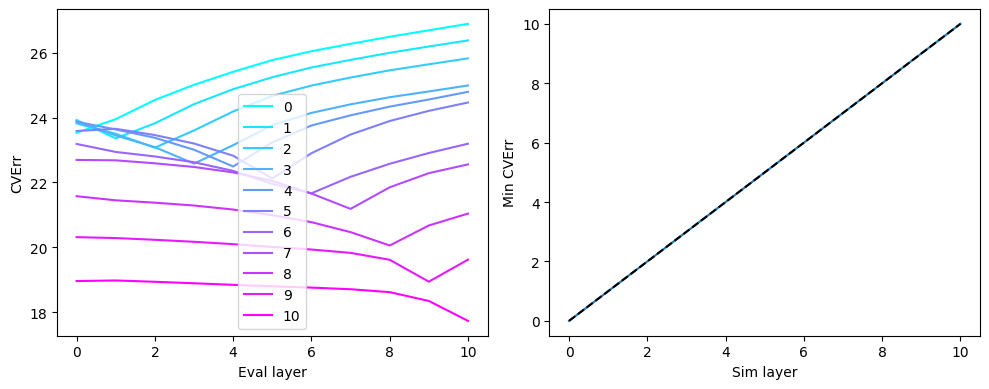

In [18]:
col_r = plt.cm.cool(np.linspace(0,1, num=surf_set.n_layers))
plt.figure(figsize=(10,4))

# For each simulation, plot the CV error of each layer model relative to that of the worst
# model for that simulation
plt.subplot(1,2,1)
for l in range(surf_set.n_layers):
    layerCvErr=all_layerCvErr[l,:]
    plt.plot(layerCvErr, label=f'{l}', color=col_r[l,:])
plt.legend()
plt.xlabel('Eval layer')
plt.ylabel('CVErr')

# For each simulation, find which layer model had the lowest CV error
plt.subplot(1,2,2)
peaks=[]
for l in range(surf_set.n_layers):
    layerCvErr=all_layerCvErr[l,:]
    pk=np.argmin(layerCvErr)
    peaks.append(pk)
plt.plot(peaks)
plt.xlim([-0.5,10.5])
plt.ylim([-0.5,10.5])
plt.plot([0,10],[0,10],'k--')
plt.xlabel('Sim layer')
plt.ylabel('Min CVErr')
plt.tight_layout()

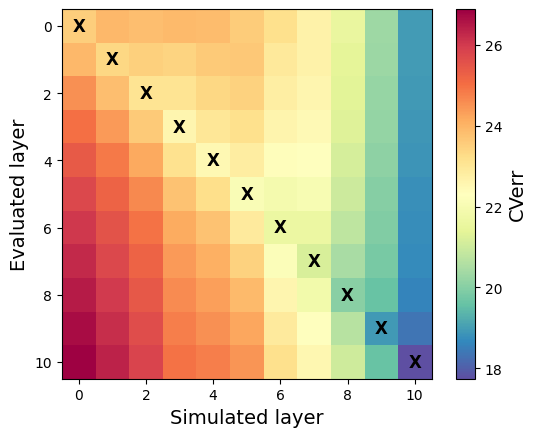

In [19]:
# Transpose for visualization
im=plt.imshow(all_layerCvErr.T, cmap='Spectral_r')

# Find the indices of the min value in each column
min_indices = np.argmin(all_layerCvErr, axis=1)

# Plot an 'X' at the center of the square for each column's minimum
for idx, min_idx in enumerate(min_indices):
    plt.text(idx, min_idx, 'X', fontsize=12, ha='center', va='center', color='black', weight='bold')

plt.xlabel('Simulated layer', fontsize=14)
plt.ylabel('Evaluated layer', fontsize=14)
cb=plt.colorbar(im)
cb.set_label('CVerr', fontsize=14)

In [20]:
spm.terminate()

# Delete simulation files
shutil.rmtree(tmp_dir)